**Surprise : Libreria orientada a sistemas de recomendacion**
<br>
**TensorFlow Recommenders: Basado en la libreria tensorflow, considera modelo de recomendación con redes neuronales**

Los codigos ejemplos desarrollados tienen como base los codigos ejemplo de las siguientes paginas (y paginas vinculadas):<br>
- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/quickstart.ipynb#scrollTo=sT8AyHRMNh41

**NOTA**: Se recomienda el bloque **"3"** dado que es el que con mayor detalle se ha cubierto el analisis de datos para filtros colaborativos.

# 1. Librerias

In [1]:
# librerias

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, NormalPredictor, Reader, SVD,KNNBasic,accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import NMF
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

# 2. [Basico] Ejemplo de sistema de recomendación basico 

In [10]:
# Crear matriz de usuarios - elementos - puntaje

ratings_dict = {
    
    "itemID": [1, 1, 2, 2, 2, 2, 1],
    "userID": [30, 2, 37, "user1", 8, 30, "user1"],
    "rating": [2, 4, 3, 1, 2, 5, 5],
}

# convertir a dataframe
df = pd.DataFrame(ratings_dict)

# Eliminar duplicados
df = df.groupby(["userID","itemID"]).agg(np.median).reset_index()
df["rating"] = pd.to_numeric(df["rating"],errors="coerce",downcast="integer")

# Ordenar valores
df = df.sort_values(["userID","itemID"])
df

userID  itemID  rating
0      2       1       4
1      8       2       2
2     30       1       2
3     30       2       5
4     37       2       3
5  user1       1       5
6  user1       2       1

In [11]:
# Ver tabla en formato de recomendacion
pd.pivot_table(df,index='userID', columns='itemID', values='rating', aggfunc='median').fillna("")

itemID    1    2
userID          
2       4.0     
8            2.0
30      2.0  5.0
37           3.0
user1   5.0  1.0

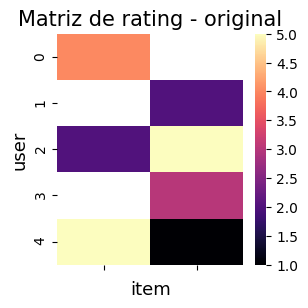

In [381]:
# Visualizar datos de rating

# rangos rating
rating_min = 1
rating_max = 5

# aspectos figura
figx = 3
figy = 3

# data
data_pivot = pd.pivot_table(df,index='userID', columns='itemID', values='rating', aggfunc='median')
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=rating_min,vmax=rating_max,yticklabels=nombres)
ax.set_title("Matriz de rating - original", fontsize = 15)
ax.set_xlabel('item', fontsize = 13)
ax.set_ylabel('user', fontsize = 13)
#ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

In [382]:
# Transformacion de datos y generacion de Train/Test

# Indicar rango de puntajes
reader = Reader(rating_scale=(1, 5))

# Convertir a formato indicando rango de valores para el puntaje
data = Dataset.load_from_df(df[["userID", "itemID", "rating"]], reader)

########################

# Generar particion en Train-Test
test_porcentaje = 0.15
trainset, testset = train_test_split(data, test_size=test_porcentaje,random_state=1234)

## 2.1. Filtro colaborativo con similitud entre usuarios

Se usan los algoritmos con similutd entre usuarios (users): KNNBasics, KNNwithMeans, KNNwithZscore

In [405]:
# Aplicar Filtro Colaborativo con similitud entre usuarios - KNNBasic

from surprise import KNNBasic

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

########################

# Ajustar segun datos Train
modelo.fit(trainset)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  2.6
MSE :  6.76
MAE :  2.6


In [406]:
# Aplicar Filtro Colaborativo con similitud entre usuarios - KNNWithMeans

from surprise import KNNWithMeans

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNWithMeans(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) # adicional se colocar parametro "k" (k=N)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  3.536
MSE :  12.5
MAE :  3.5


In [407]:
# Aplicar Filtro Colaborativo con similitud entre usuarios - KNNWithZScore

from surprise import KNNWithZScore

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNWithZScore(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) # adicional se colocar parametro "k" (k=N)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  3.536
MSE :  12.5
MAE :  3.5


In [408]:
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = df.userID.unique().tolist()
else:
    valores = df.itemID.unique().tolist()
    
pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)

Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the cosine similarity matrix...
Done computing similarity matrix.


2    8   30   37  user1
2      1.0  0.0  0.0  1.0    0.0
8      0.0  1.0  1.0  0.0    1.0
30     0.0  1.0  1.0  0.0    1.0
37     1.0  0.0  0.0  1.0    0.0
user1  0.0  1.0  1.0  0.0    1.0

Computing the cosine similarity matrix...
Done computing similarity matrix.


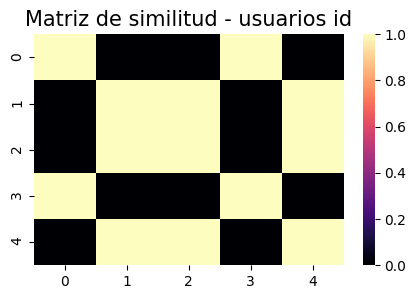

In [409]:
# Visualizar matriz de similitud

# rangos similitud
sim_min = 0
sim_max = 1

# aspectos figura
figx = 5
figy = 3

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max,yticklabels=nombres,xticklabels=nombres)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
plt.show()

## 2.2. Filtro colaborativo por cercania con similitud entre elementos

Se usan los algoritmos con similutd entre elementos (items): KNNBasics, KNNwithMeans, KNNwithZscore

In [392]:
# Aplicar Filtro Colaborativo con similitud entre elementos - KNNBasic

from surprise import KNNBasic

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = 0  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

########################

# Ajustar segun datos Train
modelo.fit(trainset)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Similitud entre usuarios [1:Si, 0:No]: 0
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  2.6
MSE :  6.76
MAE :  2.6


In [393]:
# Aplicar Filtro Colaborativo con similitud entre elementos - KNNWithMeans

from surprise import KNNWithMeans

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = 0  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNWithMeans(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) # adicional se colocar parametro "k" (k=N)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Similitud entre usuarios [1:Si, 0:No]: 0
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  2.55
MSE :  6.5
MAE :  2.5


In [394]:
# Aplicar Filtro Colaborativo con similitud entre elementos - KNNWithZScore

from surprise import KNNWithZScore

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = 0  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNWithZScore(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) # adicional se colocar parametro "k" (k=N)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Similitud entre usuarios [1:Si, 0:No]: 0
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  2.55
MSE :  6.5
MAE :  2.5


In [398]:
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = df.userID.unique().tolist()
else:
    valores = df.itemID.unique().tolist()
    
pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)

Tipo similitud basado en usuario [1:si;0:no]:  0
Computing the cosine similarity matrix...
Done computing similarity matrix.


1    2
1  1.0  0.0
2  0.0  1.0

Computing the cosine similarity matrix...
Done computing similarity matrix.


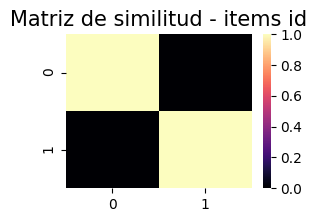

In [400]:
# Visualizar matriz de similitud

# rangos similitud
sim_min = 0
sim_max = 1

# aspectos figura
figx = 3
figy = 2

# tipo grafica
tipo = "items id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max,yticklabels=nombres,xticklabels=nombres)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
plt.show()

## 2.3. Filtro segun factorizacion de matriz

Se usan los algoritmos: SVD, SVDpp, NMF

In [410]:
# Aplicar Factorizacion de Matrices - SVD

from surprise import SVD

########################
## Definir modelo

### Seleccion de modelo
modelo = SVD(
    n_epochs = 1000,
    biased = False,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Cantidad de factores segun modelo entrenado: 100
RMSE:  4.0
MSE :  16.0
MAE :  4.0


In [411]:
# Aplicar Factorizacion de Matrices - SVDpp

from surprise import SVDpp

########################
## Definir modelo

### Seleccion de modelo
modelo = SVDpp(
    n_epochs = 1000,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Cantidad de factores segun modelo entrenado: 20
RMSE:  3.276
MSE :  10.735
MAE :  3.276


In [412]:
# Aplicar Factorizacion de Matrices - NMF

from surprise import NMF

########################
## Definir modelo

### Seleccion de modelo
modelo = NMF(
    n_epochs = 1000,
    biased = False,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

##########################
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

Cantidad de factores segun modelo entrenado: 15
RMSE:  3.823
MSE :  14.613
MAE :  3.818


In [413]:
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = df.userID.unique().tolist()
else:
    valores = df.itemID.unique().tolist()
    
pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)

Tipo similitud basado en usuario [1:si;0:no]:  True


2    8   30   37  user1
2      1.0  0.0  0.0  0.2    0.0
8      0.0  1.0  0.5  0.0    0.5
30     0.0  0.5  1.0  0.0    0.2
37     0.2  0.0  0.0  1.0    0.0
user1  0.0  0.5  0.2  0.0    1.0

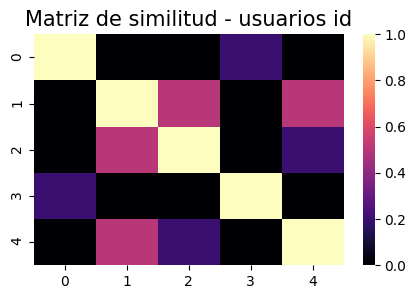

In [414]:
# Visualizar matriz de similitud

# rangos similitud
sim_min = 0
sim_max = 1

# aspectos figura
figx = 5
figy = 3

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max,yticklabels=nombres,xticklabels=nombres)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
plt.show()

## 2.4. Prediccion con modelo entrenado

Con alguno de los bloques que ajusta el modelo mediante el algoritmo se usa aqui para evaluar las predicciones

In [208]:
# Prediccion con datos Test y evaluacion de rendimiento

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

predicciones

RMSE:  0.707
MSE :  0.5
MAE :  0.5


[Prediction(uid=30, iid=1, r_ui=2.0, est=1, details={'was_impossible': False}),
 Prediction(uid='user1', iid=2, r_ui=1.0, est=1, details={'was_impossible': False})]

In [209]:
# Prediccion personalizadas (ingreso de datos a predecir)

# Usuari & Item a predecir
user_id = [45,9]
item_id = [2,2]

# Recorre cada par (user_id,item_id), en caso se tiene el valor de puntaje real indicar en "r_ui" (real rating)
for user,item in zip(user_id,item_id):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 45         item: 2          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 9          item: 2          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}


In [210]:
# Prediccion de todos los datos origen

# Usuari & Item a predecir
user_id = df.userID.tolist()
item_id = df.itemID.tolist()

# Recorre cada par (user_id,item_id), en caso se tiene el valor de puntaje real indicar en "r_ui" (real rating)
for user,item in zip(user_id,item_id):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 2          item: 1          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 8          item: 2          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 30         item: 1          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 30         item: 2          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 37         item: 2          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: user1      item: 1          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: user1      item: 2          r_ui = None   est = 3.80   {'was_impossible': True, 'reason': 'User and item are unknown.'}


Observamos que al tener pocos datos tanto de usuarios & elementos, el modelo determinó un espacio latente poco (1 dimension) por lo que los valores predichos no variarán mucho. Verlo como que posee pocos grados de libertad en los valores de recomendación predicha.

# 3. [Mejor bloque] Ejemplo de sistema de recomendación completo

En esta sección se realizará la aplicación de sistemas de recomendación mediante filtro colaborativo eligiendose ya sea usuario o item como variable de calculo de similitud. La importancia de filtrar los usuarios o elementos con pocos datos para poder realizar el calculo de similitud es importante.

## 3.1. Opcion de seleccion de N usuarios (user)

Del dataset disponible en la libreria surprise se va filtrar/seleccionar una cantidad de registros acordes a N usuarios. Con ello se entrenará el modelo de "factorizacion de matriz"

In [93]:
# Indicar cantidad minima de registros por cada tipo

# Aqui como se escoge por usuarios, se debe filtrar segun usuarios y no por elementos
min_reg_user = 4
min_reg_item = 1

print('Valor minimo de registros por user:',min_reg_user)
print('Valor minimo de registros por item:',min_reg_item)

Valor minimo de registros por user: 4
Valor minimo de registros por item: 1


In [94]:
# Cargar datos y seleccionar N usuarios

# Seleccionar aleatoriamente N usuarios
n_users = 10

## Datasets disponibles: "movielens-100k", "movielens-1m" , "Jester"
dataset = "ml-100k"

# Setear semilla para reproducibilidad
random.seed(123)

##############################
# Cargar datos

data = Dataset.load_builtin(dataset)

# convertir a dataframe
data_df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])[["user_id","item_id","rating"]]
data_df_copy = data_df.copy() # copia de dataframe original, dado que se va transformar

# Eliminar duplicados
data_df = data_df.groupby(["user_id","item_id"]).agg(np.median).reset_index()
data_df["rating"] = pd.to_numeric(data_df["rating"],errors="coerce",downcast="integer")


##############################
# Filtrar registros segun umbrales minimos de registros (user & item)

item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})

#####

lista_item_remueve = item_cuenta[item_cuenta.cuenta < min_reg_item]["item_id"].tolist()
lista_user_remueve = user_cuenta[user_cuenta.cuenta < min_reg_user]["user_id"].tolist()

# Remover elementos con cantidad inferiores al umbral minimo
n_inicio = data_df.shape[0]
data_df = data_df[~data_df.user_id.isin(lista_user_remueve)].copy()
data_df = data_df[~data_df.item_id.isin(lista_item_remueve)].copy()
n_final = data_df.shape[0]

print('-------------------------------------')
print('Cantidad registros :: inicio:',n_inicio,' ; final:',n_final,' ; diferencia:',n_inicio-n_final,' - equiv.(%):',np.round(100.0*(n_final/n_inicio),1))
print('-------------------------------------')


# Calcular de nuevo KPI's luego de filtrado 
item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
item_rating = pd.DataFrame(data_df[["item_id","rating"]].groupby("item_id").agg([np.mean,np.std])).reset_index()
item_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in item_rating.columns]
item_rating.fillna(0,inplace=True) 

user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_rating = pd.DataFrame(data_df[["user_id","rating"]].groupby("user_id").agg([np.mean,np.std])).reset_index()
user_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in user_rating.columns]
user_rating.fillna(0,inplace=True) 

item_kpi = item_cuenta.merge(item_rating,how="inner",on="item_id")
user_kpi = user_cuenta.merge(user_rating,how="inner",on="user_id")

##############################
# Filtrar usuarios (N personas)

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista de usuarios
user_ids = data_df.sort_values("user_id").user_id.unique().tolist()

# Hacer un random shuffle a la lista
random.shuffle(user_ids)
print('Usuarios seleccionados [user_id]:',user_ids[:n_users])

# seleccionar ID de los primeros N usuarios
print('Cantidad de usuarios: ',n_users)
data_df = data_df[data_df.user_id.isin(user_ids[:n_users])]

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista valores
valores_user = data_df.user_id.unique().tolist()
valores_item = data_df.item_id.unique().tolist()

data_df

-------------------------------------
Cantidad registros :: inicio: 100000  ; final: 100000  ; diferencia: 0  - equiv.(%): 100.0
-------------------------------------
Usuarios seleccionados [user_id]: ['793', '622', '37', '770', '888', '651', '729', '608', '480', '745']
Cantidad de usuarios:  10


user_id item_id  rating
32257      37    1027       3
32258      37      11       4
32259      37     117       4
32260      37     118       2
32261      37     121       2
...       ...     ...     ...
92435     888     644       4
92436     888      69       4
92437     888     762       5
92438     888     792       5
92439     888     869       4

[749 rows x 3 columns]

In [95]:
# Ver tabla en formato de recomendacion
pd.pivot_table(data_df,index='user_id', columns='item_id', values='rating', aggfunc='median').fillna("")

item_id    1   10  100 1007 1009  101 1012 1014 1016 1027  ...  969   97  977  \
user_id                                                    ...                  
37                                                    3.0  ...                  
480                4.0  4.0                                ...                  
608                4.0       4.0                           ...  5.0  3.0        
622      3.0       5.0            5.0            3.0       ...            2.0   
651                                                        ...                  
729                                                        ...                  
745      2.0  5.0  5.0                                     ...                  
770      5.0       5.0                 5.0                 ...                  
793      4.0       4.0                      3.0            ...                  
888                4.0                                     ...                  

item_id  978  979   98  988   99  993  995  
user_id                                     
37                                          
480                4.0                      
608                5.0                      
622      2.0       5.0       4.0  4.0       
651                                    1.0  
729                                         
745                5.0                      
770                     3.0                 
793           3.0                           
888                                         

[10 rows x 471 columns]

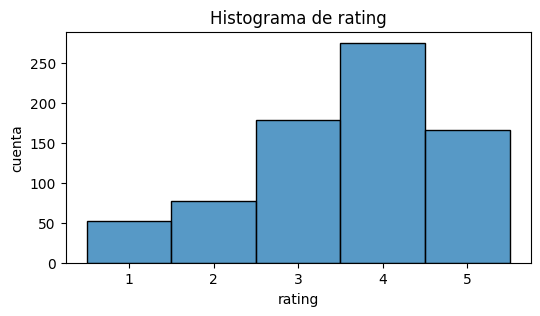

In [96]:
# histograma de ratings

plt.figure(figsize=(6,3))
sns.histplot(data=data_df,x="rating",discrete=True,stat="count")
plt.title('Histograma de rating')
plt.ylabel("cuenta")
plt.show()

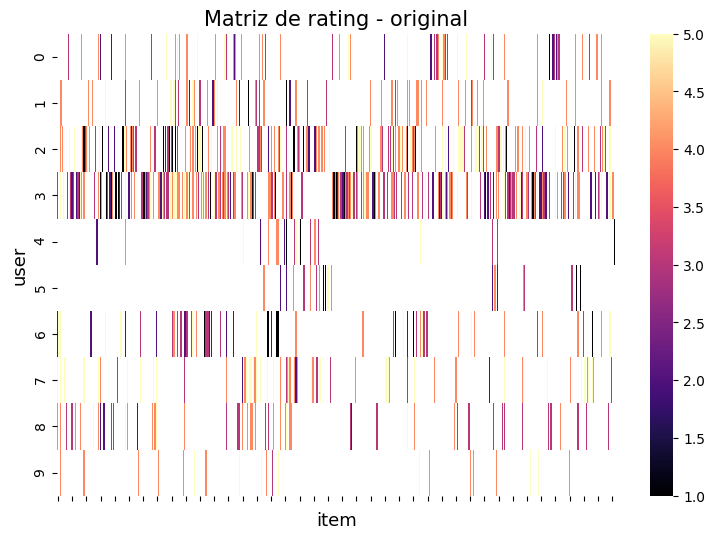

In [97]:
# Visualizar datos de rating

# rangos rating
rating_min = 1
rating_max = 5

# aspectos figura
figx = 9
figy = 6

# data
data_pivot = pd.pivot_table(data_df,index='user_id', columns='item_id', values='rating', aggfunc='median')
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=rating_min,vmax=rating_max,yticklabels=nombres)
ax.set_title("Matriz de rating - original", fontsize = 15)
ax.set_xlabel('item', fontsize = 13)
ax.set_ylabel('user', fontsize = 13)
#ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

In [98]:
# Transformar datos - Train/Test

# Indicar rango de puntajes
reader = Reader(rating_scale=(1, 5))

# Convertir a formato indicando rango de valores para el puntaje
data_df = Dataset.load_from_df(data_df[["user_id", "item_id", "rating"]], reader)

########################

# Generar particion en Train-Test
test_porcentaje = 0.15
trainset, testset = train_test_split(data_df, test_size=test_porcentaje,random_state=123)

Algoritmo de aprendizaje

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  1.254
MSE :  1.572
MAE :  1.009
----------------------------------------
Opcion de modelo: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the cosine similarity matrix...
Done computing similarity matrix.


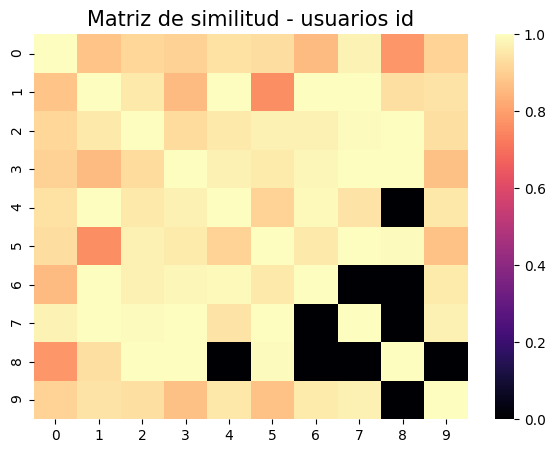

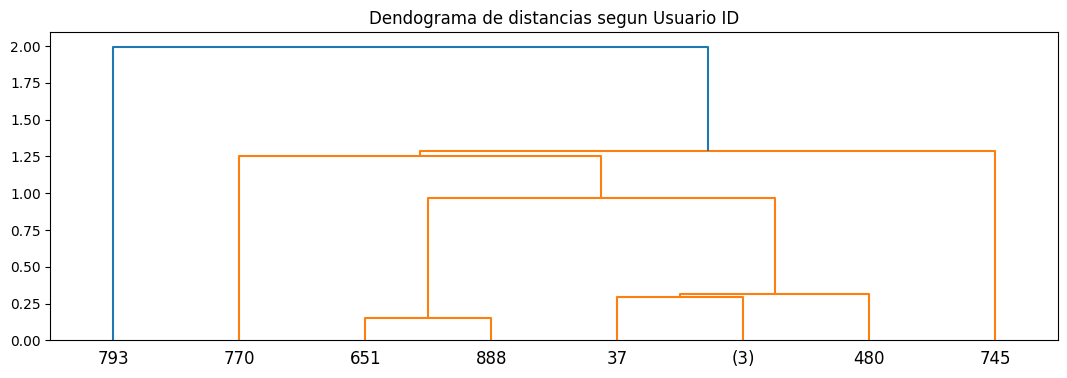

37       480       608       622       651       729       745  \
37   1.000000  0.877228  0.917613  0.906103  0.938035  0.930572  0.858319   
480  0.877228  1.000000  0.956674  0.857493  0.999512  0.762674  1.000000   
608  0.917613  0.956674  1.000000  0.926705  0.956264  0.969124  0.969686   
622  0.906103  0.857493  0.926705  1.000000  0.970026  0.958890  0.986570   
651  0.938035  0.999512  0.956264  0.970026  1.000000  0.907532  0.992170   
729  0.930572  0.762674  0.969124  0.958890  0.907532  1.000000  0.956365   
745  0.858319  1.000000  0.969686  0.986570  0.992170  0.956365  1.000000   
770  0.974835  1.000000  0.994850  1.000000  0.943701  1.000000  0.000000   
793  0.780488  0.936586  1.000000  1.000000  0.000000  0.994265  0.000000   
888  0.909453  0.944051  0.934129  0.870543  0.949265  0.872868  0.960491   

          770       793       888 grupo  
37   0.974835  0.780488  0.909453    C1  
480  1.000000  0.936586  0.944051    C1  
608  0.994850  1.000000  0.934129   NaN  
622  1.000000  1.000000  0.870543   NaN  
651  0.943701  0.000000  0.949265    C1  
729  1.000000  0.994265  0.872868   NaN  
745  0.000000  0.000000  0.960491    C1  
770  1.000000  0.000000  0.970143    C1  
793  0.000000  1.000000  0.000000    C0  
888  0.970143  0.000000  1.000000    C1

In [20]:
# (Opcion 1) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# rangos similitud
sim_min = 0
sim_max = 1

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max,yticklabels=nombres,xticklabels=nombres)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
plt.show()


# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

# ver dataframe
data_pivot

Cantidad de factores segun modelo entrenado: 100
RMSE:  1.156
MSE :  1.337
MAE :  0.921
----------------------------------------
Opcion de modelo: SVD
Tipo similitud basado en usuario [1:si;0:no]:  True


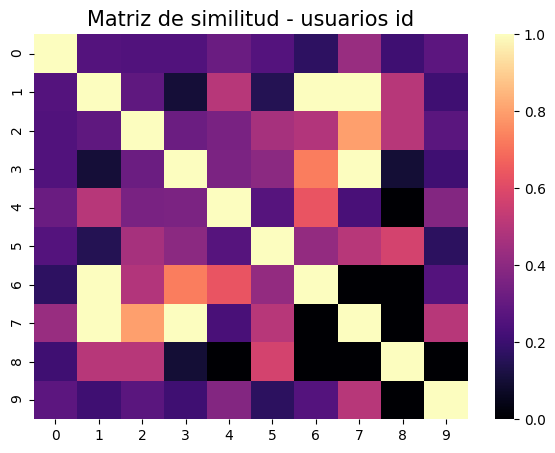

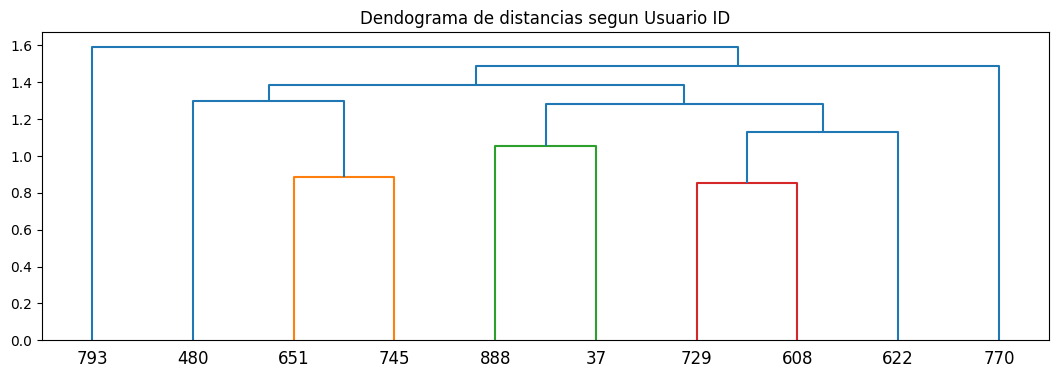

37       480       608       622       651       729       745  \
37   1.000000  0.258065  0.253425  0.250000  0.315789  0.260000  0.169231   
480  0.258065  1.000000  0.285714  0.105263  0.500000  0.148148  1.000000   
608  0.253425  0.285714  1.000000  0.318841  0.351852  0.461538  0.490909   
622  0.250000  0.105263  0.318841  1.000000  0.357143  0.395349  0.727273   
651  0.315789  0.500000  0.351852  0.357143  1.000000  0.263158  0.636364   
729  0.260000  0.148148  0.461538  0.395349  0.263158  1.000000  0.416667   
745  0.169231  1.000000  0.490909  0.727273  0.636364  0.416667  1.000000   
770  0.428571  1.000000  0.800000  1.000000  0.230769  0.500000  0.000000   
793  0.210526  0.500000  0.500000  0.100000  0.000000  0.571429  0.000000   
888  0.280702  0.210526  0.273810  0.209302  0.378378  0.164179  0.259259   

          770       793       888 grupo  
37   0.428571  0.210526  0.280702    C2  
480  1.000000  0.500000  0.210526    C0  
608  0.800000  0.500000  0.273810    C3  
622  1.000000  0.100000  0.209302    C0  
651  0.230769  0.000000  0.378378    C1  
729  0.500000  0.571429  0.164179    C3  
745  0.000000  0.000000  0.259259    C1  
770  1.000000  0.000000  0.500000    C0  
793  0.000000  1.000000  0.000000    C0  
888  0.500000  0.000000  1.000000    C2

In [99]:
# (Opcion 2) Algoritmo de factorizacion de matriz SVD

opcion_uso = "SVD"

#########################

# Definir algoritmo
modelo = SVD(
    n_epochs = 100,
    biased = True,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# rangos similitud
sim_min = 0
sim_max = 1

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max,yticklabels=nombres,xticklabels=nombres)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
plt.show()


# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

# ver dataframe
data_pivot

Cantidad de factores segun modelo entrenado: 15
RMSE:  1.415
MSE :  2.001
MAE :  1.144
----------------------------------------
Opcion de modelo: NMF
Tipo similitud basado en usuario [1:si;0:no]:  True


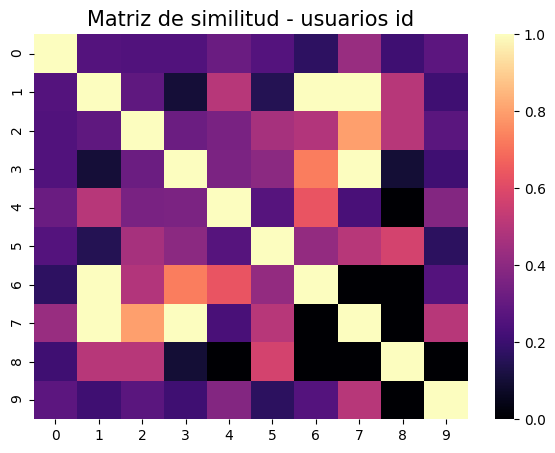

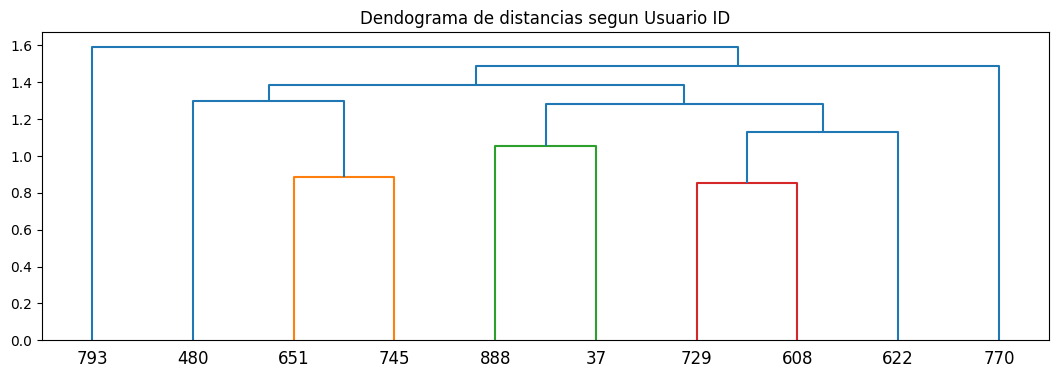

37       480       608       622       651       729       745  \
37   1.000000  0.258065  0.253425  0.250000  0.315789  0.260000  0.169231   
480  0.258065  1.000000  0.285714  0.105263  0.500000  0.148148  1.000000   
608  0.253425  0.285714  1.000000  0.318841  0.351852  0.461538  0.490909   
622  0.250000  0.105263  0.318841  1.000000  0.357143  0.395349  0.727273   
651  0.315789  0.500000  0.351852  0.357143  1.000000  0.263158  0.636364   
729  0.260000  0.148148  0.461538  0.395349  0.263158  1.000000  0.416667   
745  0.169231  1.000000  0.490909  0.727273  0.636364  0.416667  1.000000   
770  0.428571  1.000000  0.800000  1.000000  0.230769  0.500000  0.000000   
793  0.210526  0.500000  0.500000  0.100000  0.000000  0.571429  0.000000   
888  0.280702  0.210526  0.273810  0.209302  0.378378  0.164179  0.259259   

          770       793       888 grupo  
37   0.428571  0.210526  0.280702    C2  
480  1.000000  0.500000  0.210526    C0  
608  0.800000  0.500000  0.273810    C3  
622  1.000000  0.100000  0.209302    C0  
651  0.230769  0.000000  0.378378    C1  
729  0.500000  0.571429  0.164179    C3  
745  0.000000  0.000000  0.259259    C1  
770  1.000000  0.000000  0.500000    C0  
793  0.000000  1.000000  0.000000    C0  
888  0.500000  0.000000  1.000000    C2

In [22]:
# (Opcion 3) Algoritmo de recomendacion por factorizacion de matriz NMF

opcion_uso = "NMF"

########################
## Definir modelo

### Seleccion de modelo
modelo = NMF(
    n_epochs = 100,
    biased = False,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

#########################
# Predicciones

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# rangos similitud
sim_min = 0
sim_max = 1

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max,yticklabels=nombres,xticklabels=nombres)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
plt.show()


# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

# ver dataframe
data_pivot

Ver predicciones de entrenamiento

In [68]:
# Prediccion con datos Test y evaluacion de rendimiento
predicciones

[Prediction(uid='793', iid='979', r_ui=3.0, est=3.529911488879299, details={'was_impossible': False}),
 Prediction(uid='622', iid='118', r_ui=1.0, est=2.862928236412816, details={'was_impossible': False}),
 Prediction(uid='622', iid='1411', r_ui=4.0, est=3.4494929856923924, details={'was_impossible': False}),
 Prediction(uid='793', iid='237', r_ui=3.0, est=3.2608836854775762, details={'was_impossible': False}),
 Prediction(uid='37', iid='82', r_ui=1.0, est=3.4283799559905956, details={'was_impossible': False}),
 Prediction(uid='480', iid='272', r_ui=4.0, est=4.024613871974399, details={'was_impossible': False}),
 Prediction(uid='480', iid='661', r_ui=4.0, est=3.3982481853571467, details={'was_impossible': False}),
 Prediction(uid='622', iid='217', r_ui=4.0, est=3.4494929856923924, details={'was_impossible': False}),
 Prediction(uid='37', iid='226', r_ui=5.0, est=3.7692947230674205, details={'was_impossible': False}),
 Prediction(uid='622', iid='866', r_ui=2.0, est=3.4494929856923924, d

Predicciones con valores ingresados

In [25]:
# lista usuarios seleccionados
valores_user

['37', '480', '608', '622', '651', '729', '745', '770', '793', '888']

In [26]:
# lista items seleccionados
valores_item[:10]  # solo mostrar algunos

['1027', '11', '117', '118', '121', '127', '147', '161', '172', '174']

In [27]:
# Prediccion personalizadas (ingreso de datos a predecir)

# Usuari & Item a predecir
user_id = [37,480,608,622]
item_id = [11,117,118,121]

# Recorre cada par (user_id,item_id), en caso se tiene el valor de puntaje real indicar en "r_ui" (real rating)
for user,item in zip(user_id,item_id):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 37         item: 11         r_ui = None   est = 3.97   {'was_impossible': False}
user: 480        item: 117        r_ui = None   est = 3.70   {'was_impossible': False}
user: 608        item: 118        r_ui = None   est = 3.08   {'was_impossible': False}
user: 622        item: 121        r_ui = None   est = 1.18   {'was_impossible': False}


Analisis descriptivo de datos

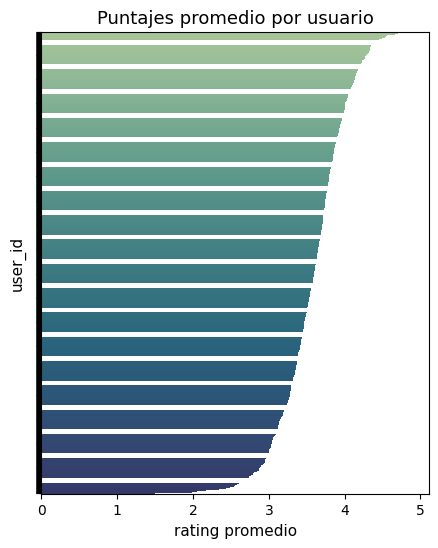

user_id  rating_mean  rating_std  cuenta
832     849     4.869565    0.344350      23
653     688     4.833333    0.637022      24
453     507     4.724138    0.767614      58
587     628     4.703704    0.724028      27
920     928     4.687500    0.692704      32
..      ...          ...         ...     ...
749     774     2.058036    1.140855     224
650     685     2.050000    0.759155      20
384     445     1.985185    1.099424     135
340     405     1.834464    1.345183     737
91      181     1.491954    0.846138     435

[943 rows x 4 columns]

In [78]:
# Ver tabla de usuarios - mayor rating

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="user_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por usuario", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

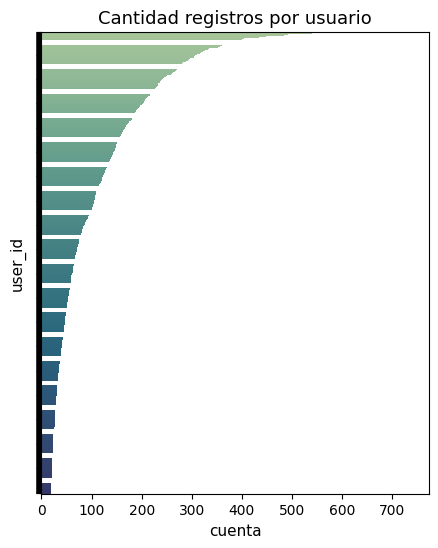

user_id  rating_mean  rating_std  cuenta
340     405     1.834464    1.345183     737
617     655     2.908029    0.732701     685
34       13     3.097484    1.416414     636
390     450     3.864815    0.862679     540
196     276     3.465251    1.017140     518
..      ...          ...         ...     ...
859     873     2.900000    1.252366      20
115     202     2.800000    1.281447      20
851     866     2.700000    1.031095      20
805     824     2.600000    0.940325      20
650     685     2.050000    0.759155      20

[943 rows x 4 columns]

In [79]:
# Ver tabla de usuarios - mayor cantidad registros

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="user_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por usuario", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

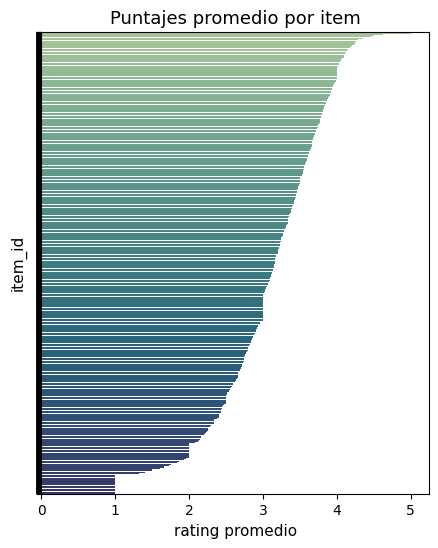

item_id  rating_mean  rating_std  cuenta
211     1189          5.0         0.0       3
327     1293          5.0         0.0       3
520     1467          5.0         0.0       2
558     1500          5.0         0.0       2
138     1122          5.0         0.0       1
...      ...          ...         ...     ...
747     1671          1.0         0.0       1
754     1678          1.0         0.0       1
1237     599          1.0         0.0       1
1495     830          1.0         0.0       1
1519     852          1.0         0.0       1

[1682 rows x 4 columns]

In [80]:
# Ver tabla de items - mayor rating

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="item_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por item", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

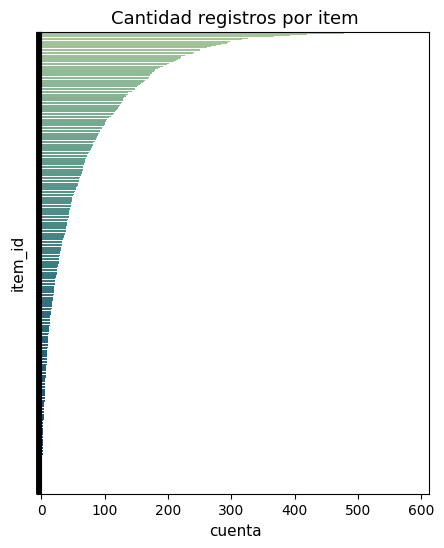

item_id  rating_mean  rating_std  cuenta
1128      50     4.358491    0.881341     583
859      258     3.803536    0.994427     509
2        100     4.155512    0.975756     508
774      181     4.007890    0.923955     507
899      294     3.156701    1.098544     485
...      ...          ...         ...     ...
747     1671     1.000000    0.000000       1
754     1678     1.000000    0.000000       1
1237     599     1.000000    0.000000       1
1495     830     1.000000    0.000000       1
1519     852     1.000000    0.000000       1

[1682 rows x 4 columns]

In [81]:
# Ver tabla de items - mayor cantidad registros

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="item_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por item", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

Ejemplo aplicación de algoritmo entrenado en usuario y item

In [100]:
# Seleccionar aleatoriamente un usuario y item

val_item = random.sample(valores_item,1)
val_user = random.sample(valores_user,1)

print('User:',val_user)
print('Item:',val_item)

User: ['480']
Item: ['157']


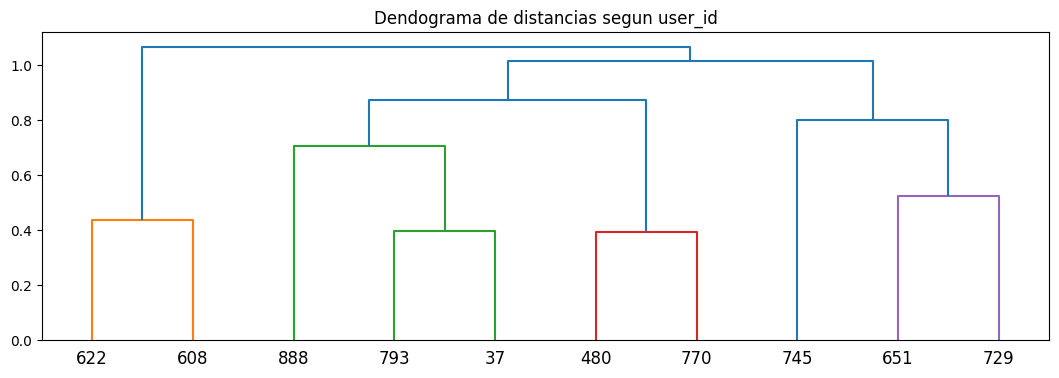

user_id   similar  cuenta  rating_mean  rating_std grupo
user_id                                                         
480         480  1.000000      60     3.733333    0.899466    C3
745         745  1.000000      60     3.100000    1.297978    C0
770         770  1.000000      64     4.296875    0.867027    C3
651         651  0.500000      21     3.285714    1.383577    C4
793         793  0.500000      55     3.509091    0.766733    C2
608         608  0.285714     163     3.674847    1.236699    C1
37           37  0.258065      57     3.649123    0.990873    C2
888         888  0.210526      20     4.300000    0.571241    C2
729         729  0.148148      21     2.857143    1.236354    C4
622         622  0.105263     228     3.390351    1.142412    C1

In [101]:
# Ranking de usuarios similares para el item seleccionado (ordenado de mayor a menor)

tipo_ref = "user_id"

valor = val_user[0]
similar = pd.DataFrame(data_pivot[valor].sort_values(ascending=False)).reset_index().rename(columns={valor:"similar","index":tipo_ref})
#similar = similar[similar[tipo_ref] != valor].copy()
similar = similar.merge(user_kpi,how="inner",on=tipo_ref)
similar.sort_values(["similar","rating_mean","rating_std","cuenta"],ascending=False)
similar.index = similar[tipo_ref]

###################

# Seleccionar variables a usar para dendograma
etiquetas = similar[tipo_ref].tolist()
df_dist = similar[["similar","rating_mean","rating_std","cuenta"]].copy()

# Normalizar variables para calculo de distancias
df_dist.rating_mean = (df_dist.rating_mean - df_dist.rating_mean.min())/(df_dist.rating_mean.max() - df_dist.rating_mean.min())
df_dist.rating_std = (df_dist.rating_std - df_dist.rating_std.min())/(df_dist.rating_std.max() - df_dist.rating_std.min())
df_dist.similar = (df_dist.similar - df_dist.similar.min())/(df_dist.similar.max() - df_dist.similar.min())
df_dist.cuenta = (df_dist.cuenta - df_dist.cuenta.min())/(df_dist.cuenta.max() - df_dist.cuenta.min())

# Dendograma segun distancias calculadas
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(pdist(df_dist,'euclidean'), 'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=5,labels=etiquetas)
plt.title('Dendograma de distancias segun ' + str(tipo_ref))
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in similar.index):
        similar.loc[elem,"grupo"] = grupo
        
###################

similar

In [102]:
# Recorre cada par (user_id,item_id) y calcular rating asignado por dicho usuario:

for user,item in zip(val_user,val_item):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 480        item: 157        r_ui = None   est = 3.51   {'was_impossible': False}


## 3.2. Opcion de seleccion de todos usuarios (user)

In [103]:
# Indicar cantidad minima de registros por cada tipo

# Aqui como se escoge por usuarios, se debe filtrar segun usuarios y no por elementos
min_reg_user = 4
min_reg_item = 1

print('Valor minimo de registros por user:',min_reg_user)
print('Valor minimo de registros por item:',min_reg_item)

Valor minimo de registros por user: 4
Valor minimo de registros por item: 1


In [104]:
# Cargar datos y seleccionar todos usuarios

## Datasets disponibles: "movielens-100k", "movielens-1m" , "Jester"
dataset = "ml-100k"

# Setear semilla para reproducibilidad
random.seed(123)

##############################
# Cargar datos

data = Dataset.load_builtin(dataset)

# convertir a dataframe
data_df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])[["user_id","item_id","rating"]]
data_df_copy = data_df.copy() # copia de dataframe original, dado que se va transformar

# Eliminar duplicados
data_df = data_df.groupby(["user_id","item_id"]).agg(np.median).reset_index()
data_df["rating"] = pd.to_numeric(data_df["rating"],errors="coerce",downcast="integer")


##############################
# Filtrar registros segun umbrales minimos de registros (user & item)

item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})

#####

lista_item_remueve = item_cuenta[item_cuenta.cuenta < min_reg_item]["item_id"].tolist()
lista_user_remueve = user_cuenta[user_cuenta.cuenta < min_reg_user]["user_id"].tolist()

# Remover elementos con cantidad inferiores al umbral minimo
n_inicio = data_df.shape[0]
data_df = data_df[~data_df.user_id.isin(lista_user_remueve)].copy()
data_df = data_df[~data_df.item_id.isin(lista_item_remueve)].copy()
n_final = data_df.shape[0]

print('-------------------------------------')
print('Cantidad registros :: inicio:',n_inicio,' ; final:',n_final,' ; diferencia:',n_inicio-n_final,' - equiv.(%):',np.round(100.0*(n_final/n_inicio),1))
print('-------------------------------------')


# Calcular de nuevo KPI's luego de filtrado 
item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
item_rating = pd.DataFrame(data_df[["item_id","rating"]].groupby("item_id").agg([np.mean,np.std])).reset_index()
item_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in item_rating.columns]
item_rating.fillna(0,inplace=True) 

user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_rating = pd.DataFrame(data_df[["user_id","rating"]].groupby("user_id").agg([np.mean,np.std])).reset_index()
user_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in user_rating.columns]
user_rating.fillna(0,inplace=True) 

item_kpi = item_cuenta.merge(item_rating,how="inner",on="item_id")
user_kpi = user_cuenta.merge(user_rating,how="inner",on="user_id")

##############################

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista de usuarios
user_ids = data_df.sort_values("user_id").user_id.unique().tolist()

# cantidad usuarios
n_users = len(user_ids)

# seleccionar ID de los primeros N usuarios
print('Cantidad de usuarios: ',n_users)

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista valores
valores_user = data_df.user_id.unique().tolist()
valores_item = data_df.item_id.unique().tolist()

data_df

-------------------------------------
Cantidad registros :: inicio: 100000  ; final: 100000  ; diferencia: 0  - equiv.(%): 100.0
-------------------------------------
Cantidad de usuarios:  943


user_id item_id  rating
0           1       1       5
1           1      10       3
2           1     100       5
3           1     101       2
4           1     102       2
...       ...     ...     ...
99995      99     931       2
99996      99     963       3
99997      99     975       3
99998      99     978       3
99999      99      98       5

[100000 rows x 3 columns]

In [105]:
# Ver tabla en formato de recomendacion
pd.pivot_table(data_df,index='user_id', columns='item_id', values='rating', aggfunc='median').fillna("")

item_id    1   10  100 1000 1001 1002 1003 1004 1005 1006  ...  990 991 992  \
user_id                                                    ...                
1        5.0  3.0  5.0                                     ...                
10       4.0       5.0                                     ...                
100                                                        ...  3.0           
101      3.0                                               ...                
102      3.0                                               ...                
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..   
95       5.0                                               ...                
96       5.0       5.0                                     ...                
97       4.0       2.0                                     ...                
98                                                         ...                
99       4.0       5.0                                     ...                

item_id  993 994 995 996 997 998 999  
user_id                               
1                                     
10                                    
100                                   
101                                   
102      2.0                          
...      ...  ..  ..  ..  ..  ..  ..  
95                                    
96                                    
97                                    
98                                    
99                                    

[943 rows x 1682 columns]

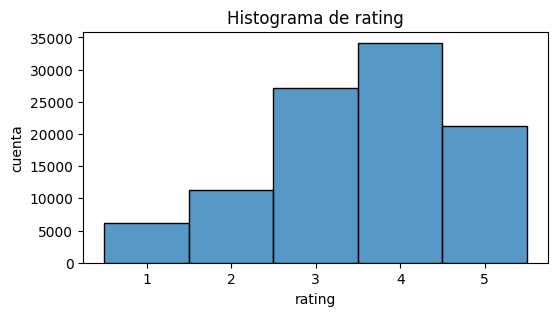

In [106]:
# histograma de ratings

plt.figure(figsize=(6,3))
sns.histplot(data=data_df,x="rating",discrete=True,stat="count")
plt.title('Histograma de rating')
plt.ylabel("cuenta")
plt.show()

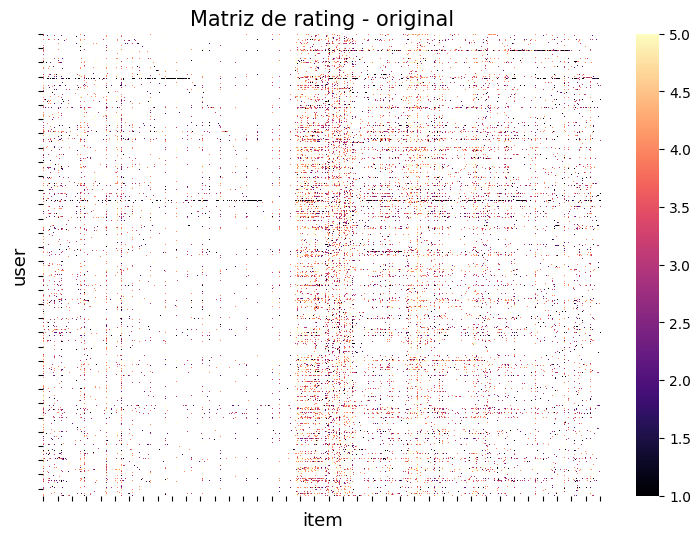

In [107]:
# Visualizar datos de rating

# rangos rating
rating_min = 1
rating_max = 5

# aspectos figura
figx = 9
figy = 6

# data
data_pivot = pd.pivot_table(data_df,index='user_id', columns='item_id', values='rating', aggfunc='median')
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=rating_min,vmax=rating_max)
ax.set_title("Matriz de rating - original", fontsize = 15)
ax.set_xlabel('item', fontsize = 13)
ax.set_ylabel('user', fontsize = 13)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

In [108]:
# Transformar datos - Train/Test

# Indicar rango de puntajes
reader = Reader(rating_scale=(1, 5))

# Convertir a formato indicando rango de valores para el puntaje
data_df = Dataset.load_from_df(data_df[["user_id", "item_id", "rating"]], reader)

########################

# Generar particion en Train-Test
test_porcentaje = 0.15
trainset, testset = train_test_split(data_df, test_size=test_porcentaje,random_state=123)

Algoritmo de aprendizaje

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  1.014
MSE :  1.028
MAE :  0.804
----------------------------------------
Opcion de modelo: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the cosine similarity matrix...
Done computing similarity matrix.


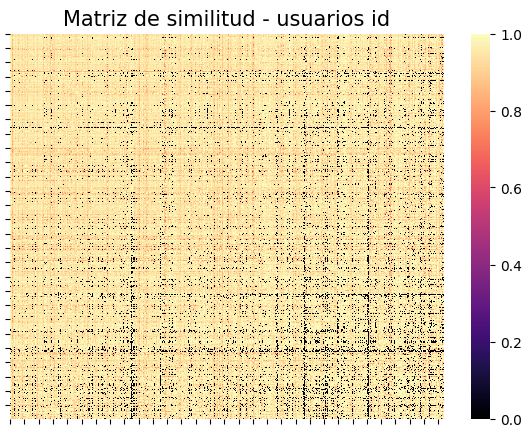

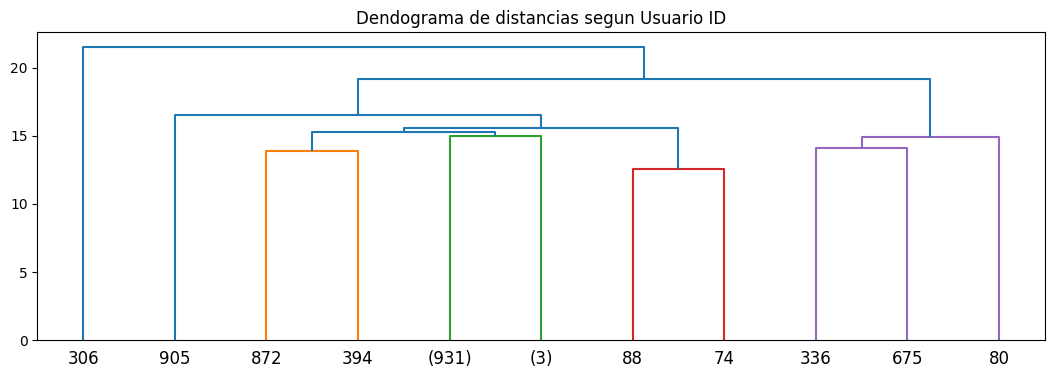

1        10       100       101       102       103       104  \
1    1.000000  0.943516  0.944486  0.971435  0.949370  0.882954  0.936368   
10   0.943516  1.000000  0.968628  0.972441  0.968382  0.828489  0.963419   
100  0.944486  0.968628  1.000000  0.958973  0.943371  0.837860  0.943234   
101  0.971435  0.972441  0.958973  1.000000  0.921000  0.796135  0.954602   
102  0.949370  0.968382  0.943371  0.921000  1.000000  0.862862  0.936197   
..        ...       ...       ...       ...       ...       ...       ...   
95   0.838659  1.000000  0.921153  0.913815  0.928601  0.855670  0.901113   
96   1.000000  0.000000  0.971537  1.000000  0.782780  0.785825  0.846830   
97   0.992795  0.990223  0.963143  0.918038  0.961298  0.882156  0.978839   
98   1.000000  0.000000  0.919145  0.960000  0.976190  0.914366  0.991741   
99   0.995863  1.000000  0.806794  0.904196  0.985245  0.882498  0.919145   

          105       106       107  ...       940       941       942  \
1    0.942871  1.000000  0.968654  ...  1.000000  0.992781  0.997054   
10   0.965351  1.000000  0.982371  ...  0.993884  1.000000  1.000000   
100  0.941865  1.000000  0.964431  ...  0.942809  0.965616  0.972134   
101  0.949639  1.000000  0.983623  ...  0.989949  0.989949  0.979958   
102  0.935620  0.998460  0.928048  ...  0.960000  0.918338  0.946354   
..        ...       ...       ...  ...       ...       ...       ...   
95   0.882994  1.000000  0.958885  ...  0.975610  0.823329  0.962250   
96   0.855921  0.894754  0.000000  ...  1.000000  0.910860  1.000000   
97   0.901057  0.000000  1.000000  ...  0.989949  1.000000  0.985611   
98   0.894427  0.969141  0.000000  ...  1.000000  0.940256  1.000000   
99   0.906444  1.000000  0.857493  ...  0.993884  1.000000  0.857493   

          943        95        96        97        98        99  grupo  
1    0.787765  0.838659  1.000000  0.992795  1.000000  0.995863    NaN  
10   0.784628  1.000000  0.000000  0.990223  0.000000  1.000000    NaN  
100  0.809007  0.921153  0.971537  0.963143  0.919145  0.806794    NaN  
101  0.934693  0.913815  1.000000  0.918038  0.960000  0.904196    NaN  
102  0.866811  0.928601  0.782780  0.961298  0.976190  0.985245    NaN  
..        ...       ...       ...       ...       ...       ...    ...  
95   0.902134  1.000000  1.000000  0.963863  0.941742  0.902134    NaN  
96   0.000000  1.000000  1.000000  1.000000  0.912903  0.713068    NaN  
97   0.957024  0.963863  1.000000  1.000000  1.000000  0.977802    NaN  
98   0.000000  0.941742  0.912903  1.000000  1.000000  0.968277    NaN  
99   0.000000  0.902134  0.713068  0.977802  0.968277  1.000000    NaN  

[943 rows x 944 columns]

In [34]:
# (Opcion 1 - sim:cosine) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE:  0.973
MSE :  0.948
MAE :  0.771
----------------------------------------
Opcion de modelo: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the msd similarity matrix...
Done computing similarity matrix.


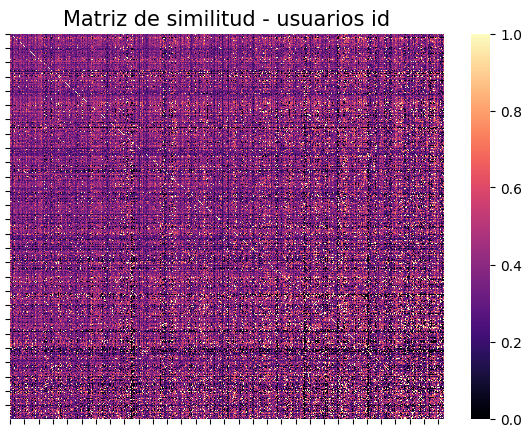

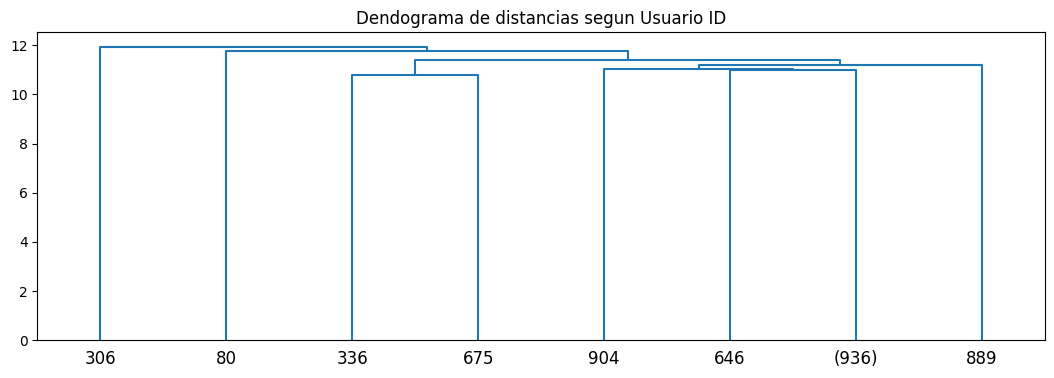

1        10       100       101       102       103       104  \
1    1.000000  0.350000  0.382353  0.463415  0.324324  0.217391  0.304000   
10   0.350000  1.000000  0.431034  0.488636  0.345912  0.142857  0.434343   
100  0.382353  0.431034  1.000000  0.407407  0.392727  0.201320  0.362550   
101  0.463415  0.488636  0.407407  1.000000  0.252033  0.125926  0.389937   
102  0.324324  0.345912  0.392727  0.252033  1.000000  0.282230  0.312925   
..        ...       ...       ...       ...       ...       ...       ...   
95   0.103448  0.200000  0.291667  0.281250  0.450000  0.250000  0.296296   
96   0.200000  0.000000  0.600000  0.100000  0.176471  0.230769  0.210526   
97   0.571429  0.384615  0.454545  0.285714  0.520000  0.159091  0.571429   
98   0.500000  0.000000  0.285714  0.500000  0.625000  0.333333  0.583333   
99   0.200000  0.500000  0.153846  0.259259  0.800000  0.172414  0.285714   

          105       106       107  ...       940       941       942  \
1    0.368932  1.000000  0.437500  ...  1.000000  0.750000  0.500000   
10   0.396226  1.000000  0.580645  ...  0.666667  1.000000  1.000000   
100  0.376147  0.200000  0.420000  ...  0.272727  0.500000  0.571429   
101  0.317829  1.000000  0.625000  ...  0.666667  0.666667  0.600000   
102  0.406593  0.500000  0.228571  ...  0.454545  0.263158  0.416667   
..        ...       ...       ...  ...       ...       ...       ...   
95   0.241379  1.000000  0.428571  ...  0.600000  0.214286  0.285714   
96   0.222222  0.187500  0.000000  ...  0.100000  0.285714  0.200000   
97   0.256410  0.000000  1.000000  ...  0.666667  1.000000  0.714286   
98   0.333333  0.333333  0.000000  ...  0.500000  0.333333  0.500000   
99   0.185185  0.500000  0.181818  ...  0.666667  0.200000  0.181818   

          943        95        96        97        98        99  grupo  
1    0.129630  0.103448  0.200000  0.571429  0.500000  0.200000    NaN  
10   0.121212  0.200000  0.000000  0.384615  0.000000  0.500000    NaN  
100  0.156863  0.291667  0.600000  0.454545  0.285714  0.153846    NaN  
101  0.333333  0.281250  0.100000  0.285714  0.500000  0.259259    NaN  
102  0.152542  0.450000  0.176471  0.520000  0.625000  0.800000    NaN  
..        ...       ...       ...       ...       ...       ...    ...  
95   0.285714  1.000000  0.100000  0.500000  0.500000  0.285714    NaN  
96   0.000000  0.100000  1.000000  1.000000  0.250000  0.107143    NaN  
97   0.333333  0.500000  1.000000  1.000000  0.200000  0.600000    NaN  
98   0.000000  0.500000  0.250000  0.200000  1.000000  0.333333    NaN  
99   0.000000  0.285714  0.107143  0.600000  0.333333  1.000000    NaN  

[943 rows x 944 columns]

In [35]:
# (Opcion 1 - sim:msd) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "msd",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo
        
##########################

# ver dataframe
data_pivot

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE:  1.007
MSE :  1.013
MAE :  0.801
----------------------------------------
Opcion de modelo: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the pearson similarity matrix...
Done computing similarity matrix.


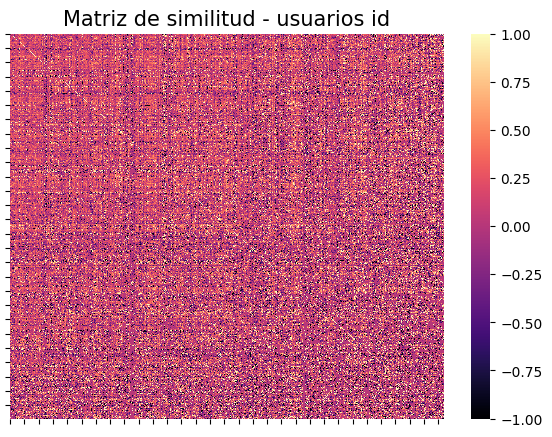

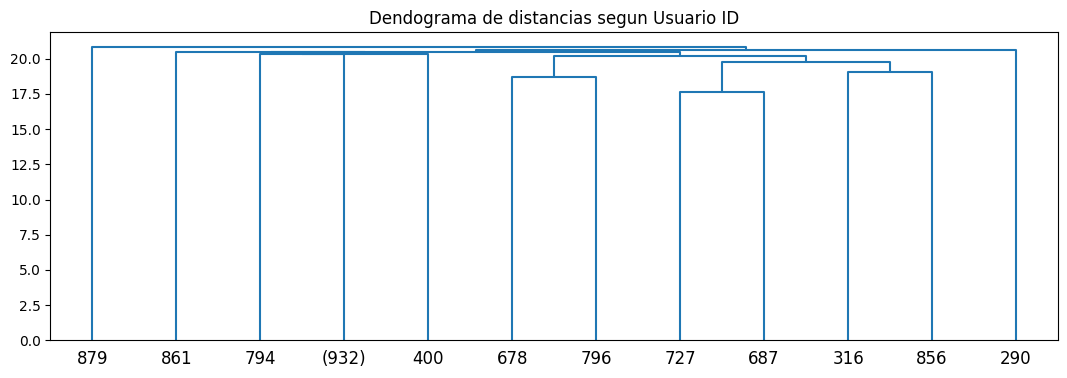

1        10       100       101       102       103       104  \
1    1.000000 -0.182098  0.295083 -0.268621  0.166838  0.003692 -0.228744   
10  -0.182098  1.000000  0.008252  0.220578  0.173736 -0.361220  0.176068   
100  0.295083  0.008252  1.000000  0.186207  0.209595  0.019939  0.274440   
101 -0.268621  0.220578  0.186207  1.000000 -0.202131 -0.239464  0.135231   
102  0.166838  0.173736  0.209595 -0.202131  1.000000  0.055960  0.070709   
..        ...       ...       ...       ...       ...       ...       ...   
95  -0.500000  0.000000 -0.509525  0.042295  0.443296 -0.086525  0.000000   
96   0.000000  0.000000  1.000000  0.000000 -0.693375  0.188982  0.440225   
97   0.870388  0.918559  0.499366 -0.054241  0.327755  0.024754  0.603023   
98   0.000000  0.000000  0.000000 -1.000000  0.931695  0.000000  0.789352   
99   1.000000  0.000000 -0.581675  0.000000  0.943880  0.111111  0.000000   

          105       106       107  ...       940       941       942  \
1   -0.130106  1.000000 -0.381881  ...  0.000000  0.866025  1.000000   
10  -0.065129  0.000000 -0.192450  ...  0.000000  0.000000  0.000000   
100  0.207270  0.000000 -0.304372  ...  0.000000  1.000000  0.666837   
101  0.223264  0.000000  0.263523  ...  0.000000  0.000000  0.000000   
102  0.019181  1.000000 -0.388772  ... -0.071429 -0.196116  0.458664   
..        ...       ...       ...  ...       ...       ...       ...   
95  -0.119416  0.000000 -0.387298  ... -0.500000 -0.755929  0.818182   
96   0.408248  0.970725  0.000000  ...  0.000000  0.727607  0.000000   
97  -0.222681  0.000000  0.000000  ...  0.000000  0.000000  0.784465   
98   0.000000  0.559017  0.000000  ...  0.000000  0.000000  0.000000   
99  -0.157243  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

          943        95        96        97        98        99  grupo  
1   -0.432801 -0.500000  0.000000  0.870388  0.000000  1.000000    NaN  
10  -0.301511  0.000000  0.000000  0.918559  0.000000  0.000000    NaN  
100 -0.347960 -0.509525  1.000000  0.499366  0.000000 -0.581675    NaN  
101  0.731925  0.042295  0.000000 -0.054241 -1.000000  0.000000    NaN  
102 -0.166667  0.443296 -0.693375  0.327755  0.931695  0.943880    NaN  
..        ...       ...       ...       ...       ...       ...    ...  
95   1.000000  1.000000  0.000000  0.174078  1.000000  1.000000    NaN  
96   0.000000  0.000000  1.000000  0.000000  0.088045 -0.891042    NaN  
97   1.000000  0.174078  0.000000  1.000000  0.000000  0.944911    NaN  
98   0.000000  1.000000  0.088045  0.000000  1.000000 -1.000000    NaN  
99   0.000000  1.000000 -0.891042  0.944911 -1.000000  1.000000    NaN  

[943 rows x 944 columns]

In [36]:
# (Opcion 1 - sim:pearson) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "pearson",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Cantidad de factores segun modelo entrenado: 100
RMSE:  0.981
MSE :  0.962
MAE :  0.77
----------------------------------------
Opcion de modelo: SVD
Tipo similitud basado en usuario [1:si;0:no]:  True


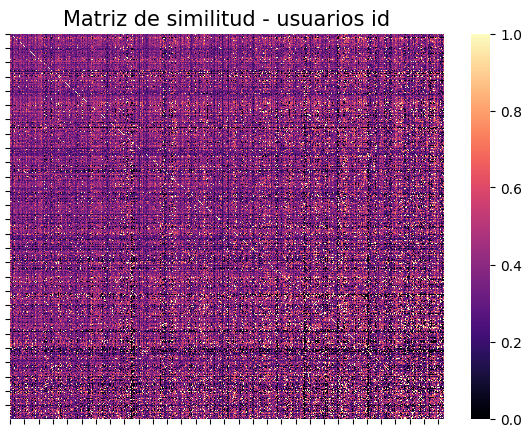

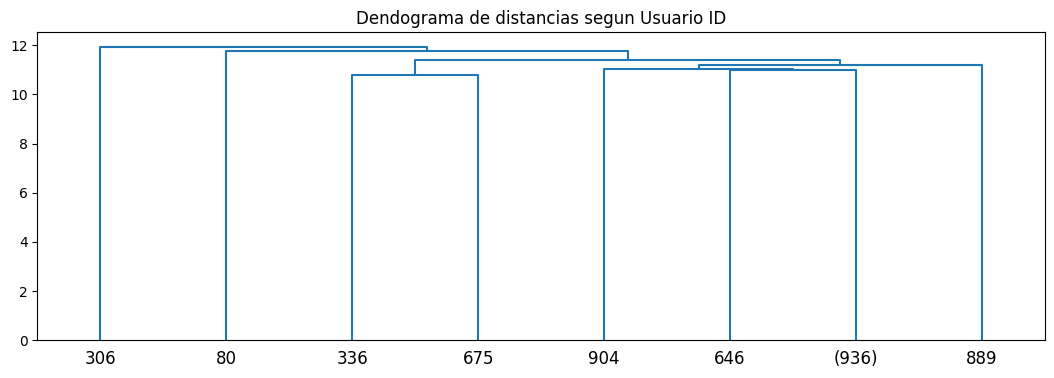

1        10       100       101       102       103       104  \
1    1.000000  0.350000  0.382353  0.463415  0.324324  0.217391  0.304000   
10   0.350000  1.000000  0.431034  0.488636  0.345912  0.142857  0.434343   
100  0.382353  0.431034  1.000000  0.407407  0.392727  0.201320  0.362550   
101  0.463415  0.488636  0.407407  1.000000  0.252033  0.125926  0.389937   
102  0.324324  0.345912  0.392727  0.252033  1.000000  0.282230  0.312925   
..        ...       ...       ...       ...       ...       ...       ...   
95   0.103448  0.200000  0.291667  0.281250  0.450000  0.250000  0.296296   
96   0.200000  0.000000  0.600000  0.100000  0.176471  0.230769  0.210526   
97   0.571429  0.384615  0.454545  0.285714  0.520000  0.159091  0.571429   
98   0.500000  0.000000  0.285714  0.500000  0.625000  0.333333  0.583333   
99   0.200000  0.500000  0.153846  0.259259  0.800000  0.172414  0.285714   

          105       106       107  ...       940       941       942  \
1    0.368932  1.000000  0.437500  ...  1.000000  0.750000  0.500000   
10   0.396226  1.000000  0.580645  ...  0.666667  1.000000  1.000000   
100  0.376147  0.200000  0.420000  ...  0.272727  0.500000  0.571429   
101  0.317829  1.000000  0.625000  ...  0.666667  0.666667  0.600000   
102  0.406593  0.500000  0.228571  ...  0.454545  0.263158  0.416667   
..        ...       ...       ...  ...       ...       ...       ...   
95   0.241379  1.000000  0.428571  ...  0.600000  0.214286  0.285714   
96   0.222222  0.187500  0.000000  ...  0.100000  0.285714  0.200000   
97   0.256410  0.000000  1.000000  ...  0.666667  1.000000  0.714286   
98   0.333333  0.333333  0.000000  ...  0.500000  0.333333  0.500000   
99   0.185185  0.500000  0.181818  ...  0.666667  0.200000  0.181818   

          943        95        96        97        98        99  grupo  
1    0.129630  0.103448  0.200000  0.571429  0.500000  0.200000    NaN  
10   0.121212  0.200000  0.000000  0.384615  0.000000  0.500000    NaN  
100  0.156863  0.291667  0.600000  0.454545  0.285714  0.153846    NaN  
101  0.333333  0.281250  0.100000  0.285714  0.500000  0.259259    NaN  
102  0.152542  0.450000  0.176471  0.520000  0.625000  0.800000    NaN  
..        ...       ...       ...       ...       ...       ...    ...  
95   0.285714  1.000000  0.100000  0.500000  0.500000  0.285714    NaN  
96   0.000000  0.100000  1.000000  1.000000  0.250000  0.107143    NaN  
97   0.333333  0.500000  1.000000  1.000000  0.200000  0.600000    NaN  
98   0.000000  0.500000  0.250000  0.200000  1.000000  0.333333    NaN  
99   0.000000  0.285714  0.107143  0.600000  0.333333  1.000000    NaN  

[943 rows x 944 columns]

In [109]:
# (Opcion 2) Algoritmo de factorizacion de matriz SVD

opcion_uso = "SVD"

#########################

# Definir algoritmo
modelo = SVD(
    n_epochs = 100,
    biased = True,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Cantidad de factores segun modelo entrenado: 15
RMSE:  0.942
MSE :  0.888
MAE :  0.743
----------------------------------------
Opcion de modelo: NMF
Tipo similitud basado en usuario [1:si;0:no]:  True


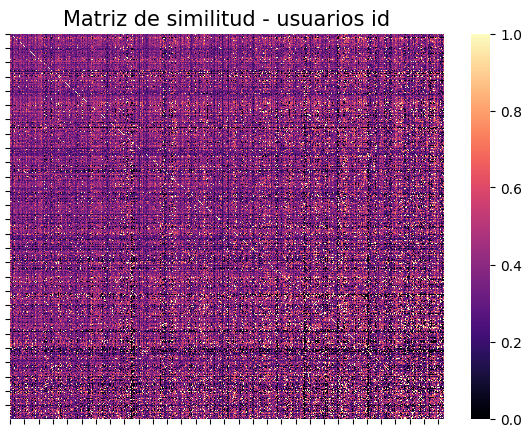

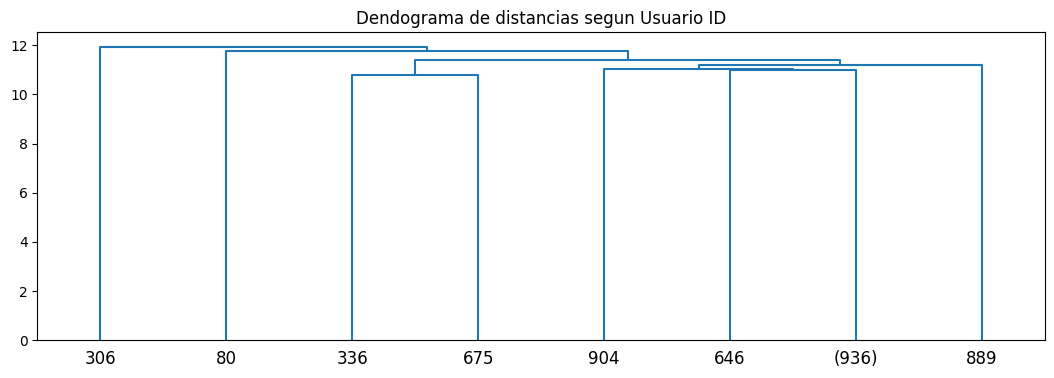

1        10       100       101       102       103       104  \
1    1.000000  0.350000  0.382353  0.463415  0.324324  0.217391  0.304000   
10   0.350000  1.000000  0.431034  0.488636  0.345912  0.142857  0.434343   
100  0.382353  0.431034  1.000000  0.407407  0.392727  0.201320  0.362550   
101  0.463415  0.488636  0.407407  1.000000  0.252033  0.125926  0.389937   
102  0.324324  0.345912  0.392727  0.252033  1.000000  0.282230  0.312925   
..        ...       ...       ...       ...       ...       ...       ...   
95   0.103448  0.200000  0.291667  0.281250  0.450000  0.250000  0.296296   
96   0.200000  0.000000  0.600000  0.100000  0.176471  0.230769  0.210526   
97   0.571429  0.384615  0.454545  0.285714  0.520000  0.159091  0.571429   
98   0.500000  0.000000  0.285714  0.500000  0.625000  0.333333  0.583333   
99   0.200000  0.500000  0.153846  0.259259  0.800000  0.172414  0.285714   

          105       106       107  ...       940       941       942  \
1    0.368932  1.000000  0.437500  ...  1.000000  0.750000  0.500000   
10   0.396226  1.000000  0.580645  ...  0.666667  1.000000  1.000000   
100  0.376147  0.200000  0.420000  ...  0.272727  0.500000  0.571429   
101  0.317829  1.000000  0.625000  ...  0.666667  0.666667  0.600000   
102  0.406593  0.500000  0.228571  ...  0.454545  0.263158  0.416667   
..        ...       ...       ...  ...       ...       ...       ...   
95   0.241379  1.000000  0.428571  ...  0.600000  0.214286  0.285714   
96   0.222222  0.187500  0.000000  ...  0.100000  0.285714  0.200000   
97   0.256410  0.000000  1.000000  ...  0.666667  1.000000  0.714286   
98   0.333333  0.333333  0.000000  ...  0.500000  0.333333  0.500000   
99   0.185185  0.500000  0.181818  ...  0.666667  0.200000  0.181818   

          943        95        96        97        98        99  grupo  
1    0.129630  0.103448  0.200000  0.571429  0.500000  0.200000    NaN  
10   0.121212  0.200000  0.000000  0.384615  0.000000  0.500000    NaN  
100  0.156863  0.291667  0.600000  0.454545  0.285714  0.153846    NaN  
101  0.333333  0.281250  0.100000  0.285714  0.500000  0.259259    NaN  
102  0.152542  0.450000  0.176471  0.520000  0.625000  0.800000    NaN  
..        ...       ...       ...       ...       ...       ...    ...  
95   0.285714  1.000000  0.100000  0.500000  0.500000  0.285714    NaN  
96   0.000000  0.100000  1.000000  1.000000  0.250000  0.107143    NaN  
97   0.333333  0.500000  1.000000  1.000000  0.200000  0.600000    NaN  
98   0.000000  0.500000  0.250000  0.200000  1.000000  0.333333    NaN  
99   0.000000  0.285714  0.107143  0.600000  0.333333  1.000000    NaN  

[943 rows x 944 columns]

In [38]:
# (Opcion 3) Algoritmo de recomendacion por factorizacion de matriz NMF

opcion_uso = "NMF"

########################
## Definir modelo

### Seleccion de modelo
modelo = NMF(
    n_epochs = 100,
    biased = False,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

#########################
# Predicciones

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

########################
########################
# Matriz de similitud entre "user_id vs user_id" o "item_id vs item_id"

print('----------------------------------------')
print('Opcion de modelo:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "usuarios id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Predicciones con valores ingresados

In [909]:
# lista usuarios seleccionados - mostrar primeros 10 
valores_user[:10]

['1', '10', '100', '101', '102', '103', '104', '105', '106', '107']

In [910]:
# lista items seleccionados - mostrar primeros 10
valores_item[:10]

['1', '10', '100', '101', '102', '103', '104', '105', '106', '107']

In [82]:
# Prediccion personalizadas (ingreso de datos a predecir)

# Usuari & Item a predecir
user_id = [10,100,101,102]
item_id = [1,10,100,101]

# Recorre cada par (user_id,item_id), en caso se tiene el valor de puntaje real indicar en "r_ui" (real rating)
for user,item in zip(user_id,item_id):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 10         item: 1          r_ui = None   est = 4.07   {'was_impossible': False}
user: 100        item: 10         r_ui = None   est = 4.24   {'was_impossible': False}
user: 101        item: 100        r_ui = None   est = 4.16   {'was_impossible': False}
user: 102        item: 101        r_ui = None   est = 3.47   {'was_impossible': False}


Analisis descriptivo de datos

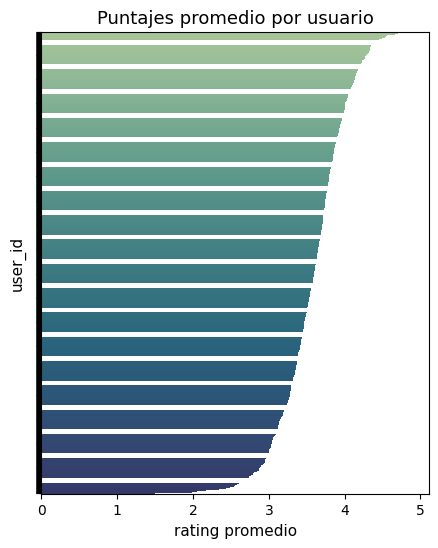

user_id  rating_mean  rating_std  cuenta
832     849     4.869565    0.344350      23
653     688     4.833333    0.637022      24
453     507     4.724138    0.767614      58
587     628     4.703704    0.724028      27
920     928     4.687500    0.692704      32
..      ...          ...         ...     ...
749     774     2.058036    1.140855     224
650     685     2.050000    0.759155      20
384     445     1.985185    1.099424     135
340     405     1.834464    1.345183     737
91      181     1.491954    0.846138     435

[943 rows x 4 columns]

In [83]:
# Ver tabla de usuarios - mayor rating

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="user_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por usuario", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

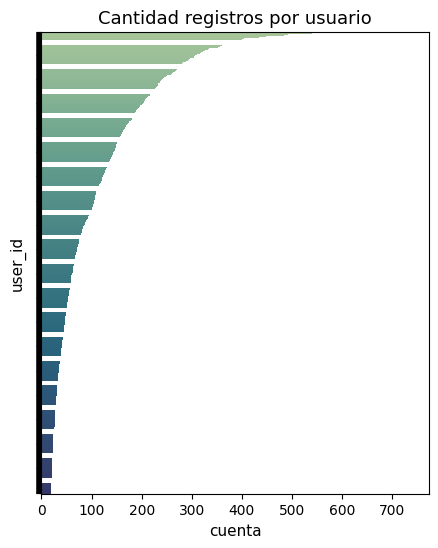

user_id  rating_mean  rating_std  cuenta
340     405     1.834464    1.345183     737
617     655     2.908029    0.732701     685
34       13     3.097484    1.416414     636
390     450     3.864815    0.862679     540
196     276     3.465251    1.017140     518
..      ...          ...         ...     ...
859     873     2.900000    1.252366      20
115     202     2.800000    1.281447      20
851     866     2.700000    1.031095      20
805     824     2.600000    0.940325      20
650     685     2.050000    0.759155      20

[943 rows x 4 columns]

In [94]:
# Ver tabla de usuarios - mayor cantidad registros

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="user_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por usuario", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

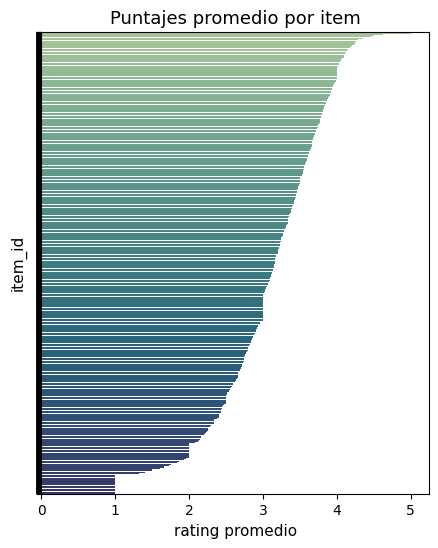

item_id  rating_mean  rating_std  cuenta
211     1189          5.0         0.0       3
327     1293          5.0         0.0       3
520     1467          5.0         0.0       2
558     1500          5.0         0.0       2
138     1122          5.0         0.0       1
...      ...          ...         ...     ...
747     1671          1.0         0.0       1
754     1678          1.0         0.0       1
1237     599          1.0         0.0       1
1495     830          1.0         0.0       1
1519     852          1.0         0.0       1

[1682 rows x 4 columns]

In [84]:
# Ver tabla de items - mayor rating

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="item_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por item", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

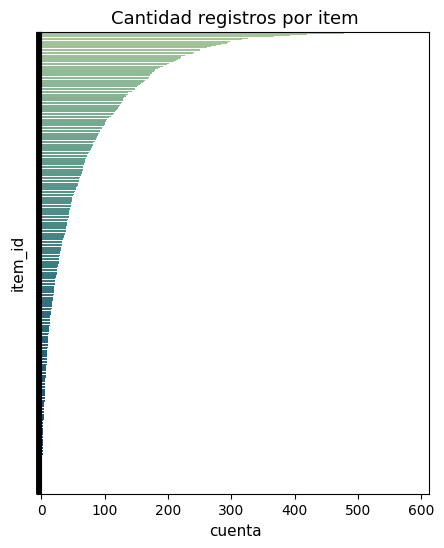

item_id  rating_mean  rating_std  cuenta
1128      50     4.358491    0.881341     583
859      258     3.803536    0.994427     509
2        100     4.155512    0.975756     508
774      181     4.007890    0.923955     507
899      294     3.156701    1.098544     485
...      ...          ...         ...     ...
747     1671     1.000000    0.000000       1
754     1678     1.000000    0.000000       1
1237     599     1.000000    0.000000       1
1495     830     1.000000    0.000000       1
1519     852     1.000000    0.000000       1

[1682 rows x 4 columns]

In [96]:
# Ver tabla de items - mayor cantidad registros

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="item_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por item", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

Ejemplo aplicación de algoritmo entrenado en usuario y item

In [110]:
# Seleccionar aleatoriamente un usuario y item

val_item = random.sample(valores_item,1)
val_user = random.sample(valores_user,1)

print('User:',val_user)
print('Item:',val_item)

User: ['346']
Item: ['196']


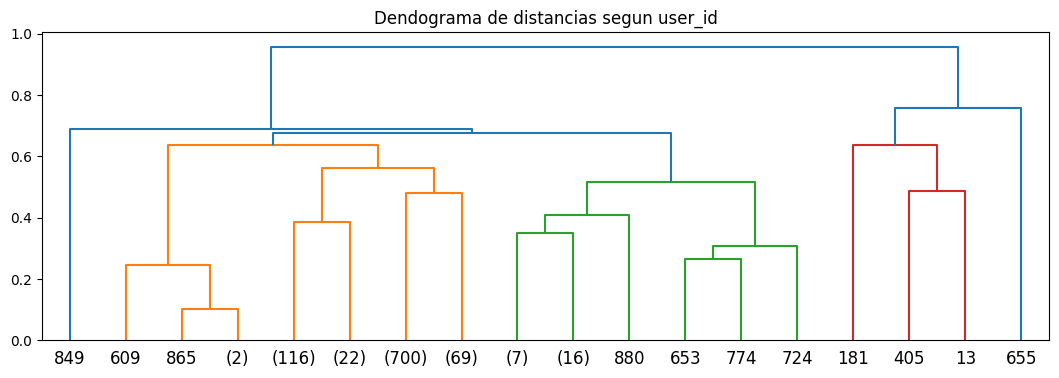

user_id  similar  cuenta  rating_mean  rating_std grupo
user_id                                                        
640         640      1.0     109     4.229358    0.812324   NaN
493         493      1.0     135     3.755556    1.187413   NaN
794         794      1.0      39     4.307692    0.731036   NaN
905         905      1.0      40     3.275000    0.784056   NaN
880         880      1.0     368     3.426630    0.982156    C2
...         ...      ...     ...          ...         ...   ...
825         825      0.0     145     3.613793    1.074879   NaN
329         329      0.0      65     3.400000    0.825379   NaN
646         646      0.0      38     2.947368    0.695443   NaN
831         831      0.0      73     3.520548    1.167971   NaN
841         841      0.0      31     3.903226    1.044185   NaN

[943 rows x 6 columns]

In [111]:
# Ranking de usuarios similares para el item seleccionado (ordenado de mayor a menor)

tipo_ref = "user_id"

valor = val_user[0]
similar = pd.DataFrame(data_pivot[valor].sort_values(ascending=False)).reset_index().rename(columns={valor:"similar","index":tipo_ref})
#similar = similar[similar[tipo_ref] != valor].copy()
similar = similar.merge(user_kpi,how="inner",on=tipo_ref)
similar.sort_values(["similar","rating_mean","rating_std","cuenta"],ascending=False)
similar.index = similar[tipo_ref]

###################

# Seleccionar variables a usar para dendograma
etiquetas = similar[tipo_ref].tolist()
df_dist = similar[["similar","rating_mean","rating_std","cuenta"]].copy()

# Normalizar variables para calculo de distancias
df_dist.rating_mean = (df_dist.rating_mean - df_dist.rating_mean.min())/(df_dist.rating_mean.max() - df_dist.rating_mean.min())
df_dist.rating_std = (df_dist.rating_std - df_dist.rating_std.min())/(df_dist.rating_std.max() - df_dist.rating_std.min())
df_dist.similar = (df_dist.similar - df_dist.similar.min())/(df_dist.similar.max() - df_dist.similar.min())
df_dist.cuenta = (df_dist.cuenta - df_dist.cuenta.min())/(df_dist.cuenta.max() - df_dist.cuenta.min())

# Dendograma segun distancias calculadas
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(pdist(df_dist,'euclidean'), 'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=5,labels=etiquetas)
plt.title('Dendograma de distancias segun ' + str(tipo_ref))
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in similar.index):
        similar.loc[elem,"grupo"] = grupo
        
###################

similar

In [112]:
# Recorre cada par (user_id,item_id) y calcular rating asignado por dicho usuario:

for user,item in zip(val_user,val_item):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 346        item: 196        r_ui = None   est = 3.10   {'was_impossible': False}


## 3.3. Opcion de seleccion de N elementos (item)

Del dataset disponible en la libreria surprise se va filtrar/seleccionar una cantidad de registros acordes a N items. Con ello se entrenará el modelo de "factorizacion de matriz"

In [113]:
# Indicar cantidad minima de registros por cada tipo

# Aqui como se escoge por elementos (item), se debe filtrar segun item y no por usuario
min_reg_user = 1
min_reg_item = 4

print('Valor minimo de registros por user:',min_reg_user)
print('Valor minimo de registros por item:',min_reg_item)

Valor minimo de registros por user: 1
Valor minimo de registros por item: 4


In [114]:
# Cargar datos y seleccionar N items (Cuidado que se invierte el orden de columnas "item_id" y "user_id")

# Seleccionar aleatoriamente N items
n_items = 10

## Datasets disponibles: "movielens-100k", "movielens-1m" , "Jester"
dataset = "ml-100k"

# Setear semilla para reproducibilidad
random.seed(123)

##############################
# Cargar datos

data = Dataset.load_builtin(dataset)

# convertir a dataframe
data_df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])[["user_id","item_id","rating"]]
data_df_copy = data_df.copy() # copia de dataframe original, dado que se va transformar

# Eliminar duplicados
data_df = data_df.groupby(["user_id","item_id"]).agg(np.median).reset_index()
data_df["rating"] = pd.to_numeric(data_df["rating"],errors="coerce",downcast="integer")

##############################
# Filtrar registros segun umbrales minimos de registros (user & item)

item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})

#####

lista_item_remueve = item_cuenta[item_cuenta.cuenta < min_reg_item]["item_id"].tolist()
lista_user_remueve = user_cuenta[user_cuenta.cuenta < min_reg_user]["user_id"].tolist()

# Remover elementos con cantidad inferiores al umbral minimo
n_inicio = data_df.shape[0]
data_df = data_df[~data_df.user_id.isin(lista_user_remueve)].copy()
data_df = data_df[~data_df.item_id.isin(lista_item_remueve)].copy()
n_final = data_df.shape[0]

print('-------------------------------------')
print('Cantidad registros :: inicio:',n_inicio,' ; final:',n_final,' ; diferencia:',n_inicio-n_final,' - equiv.(%):',np.round(100.0*(n_final/n_inicio),1))
print('-------------------------------------')


# Calcular de nuevo KPI's luego de filtrado 
item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
item_rating = pd.DataFrame(data_df[["item_id","rating"]].groupby("item_id").agg([np.mean,np.std])).reset_index()
item_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in item_rating.columns]
item_rating.fillna(0,inplace=True) 

user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_rating = pd.DataFrame(data_df[["user_id","rating"]].groupby("user_id").agg([np.mean,np.std])).reset_index()
user_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in user_rating.columns]
user_rating.fillna(0,inplace=True) 

item_kpi = item_cuenta.merge(item_rating,how="inner",on="item_id")
user_kpi = user_cuenta.merge(user_rating,how="inner",on="user_id")


###############################
###############################
# Invertir orden de columnas

## user_id* => item_id
## item_id* => user_id

# Aplicar inversion de columnas
data_df[["user_id","item_id"]] = data_df[["item_id","user_id"]].values.copy()

###############################
##############################
# Filtrar elementos (N items)

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista de items
user_ids = data_df.sort_values("user_id").user_id.unique().tolist()

# Hacer un random shuffle a la lista
random.shuffle(user_ids)
print('Elemento seleccionados [item_id]:',user_ids[:n_items])

# seleccionar ID de los primeros N elementos
print('Cantidad de elementos: ',n_items)
data_df = data_df[data_df.user_id.isin(user_ids[:n_items])]

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista valores (cuidado los valores estan invertidos)
valores_user = data_df.user_id.unique().tolist()
valores_item = data_df.item_id.unique().tolist()

data_df

-------------------------------------
Cantidad registros :: inicio: 100000  ; final: 99543  ; diferencia: 457  - equiv.(%): 99.5
-------------------------------------
Elemento seleccionados [item_id]: ['742', '264', '712', '1367', '1317', '1049', '208', '1598', '647', '594']
Cantidad de elementos:  10


user_id item_id  rating
3772     1049     130       3
6295     1049     159       4
8282     1049     181       1
10677    1049     200       3
11296    1049     203       2
...       ...     ...     ...
98594     742     938       3
98655     742     939       5
99001     742      94       3
99684     742      95       4
99978     742      99       5

[734 rows x 3 columns]

In [115]:
# Ver tabla en formato de recomendacion

pd.pivot_table(data_df.rename(columns={"user_id":"item_id","item_id":"user_id"},inplace=False),
    index='user_id', columns='item_id', values='rating', aggfunc='median').fillna("")

item_id 1049 1317 1367 1598  208  264 594  647  712  742
user_id                                                 
1                            5.0  2.0                   
10                                              4.0     
101                                                  4.0
102                          4.0  2.0                   
105                               2.0                   
...      ...  ...  ...  ...  ...  ...  ..  ...  ...  ...
94                           4.0           5.0       3.0
940                               1.0                   
95                           4.0                2.0  4.0
97                           5.0                        
99                                                   5.0

[474 rows x 10 columns]

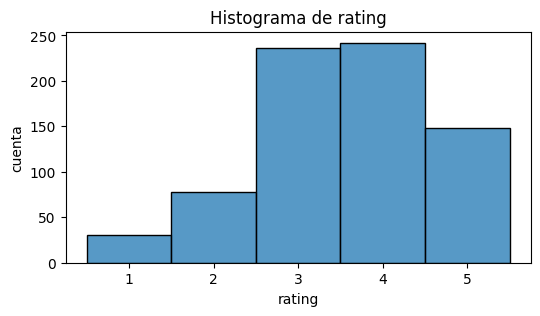

In [116]:
# histograma de ratings

plt.figure(figsize=(6,3))
sns.histplot(data=data_df,x="rating",discrete=True,stat="count")
plt.title('Histograma de rating')
plt.ylabel("cuenta")
plt.show()

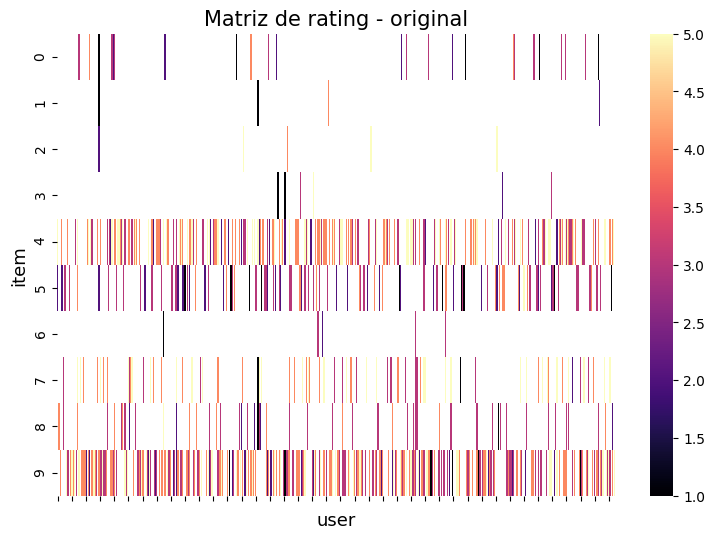

In [117]:
# Visualizar datos de rating

# rangos rating
rating_min = 1
rating_max = 5

# aspectos figura
figx = 9
figy = 6

# data
data_pivot = pd.pivot_table(data_df,index='user_id', columns='item_id', values='rating', aggfunc='median')
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=rating_min,vmax=rating_max,yticklabels=nombres)
ax.set_title("Matriz de rating - original", fontsize = 15)
ax.set_xlabel('user', fontsize = 13)
ax.set_ylabel('item', fontsize = 13)
#ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

In [118]:
# Transformar datos - Train/Test

# Indicar rango de puntajes
reader = Reader(rating_scale=(1, 5))

# Convertir a formato indicando rango de valores para el puntaje
data_df = Dataset.load_from_df(data_df[["user_id", "item_id", "rating"]], reader)

########################

# Generar particion en Train-Test
test_porcentaje = 0.15
trainset, testset = train_test_split(data_df, test_size=test_porcentaje,random_state=123)

Algoritmo de aprendizaje

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  1.144
MSE :  1.309
MAE :  0.973
-----------------------------------------
Opcion de uso: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the cosine similarity matrix...
Done computing similarity matrix.


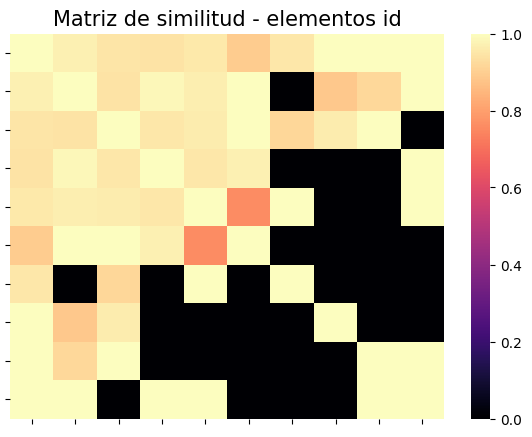

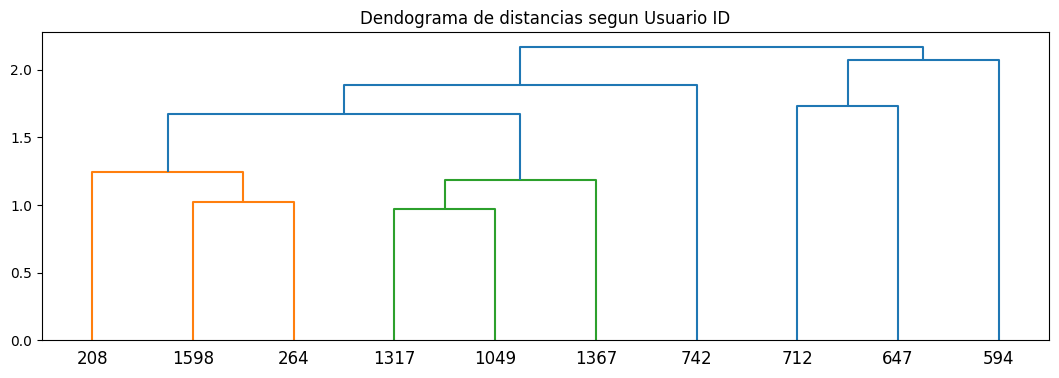

1049      1317      1367      1598       208       264       594  \
1049  1.000000  0.969590  0.949162  0.942877  0.954258  0.894427  0.950756   
1317  0.969590  1.000000  0.945308  0.985290  0.964901  1.000000  0.000000   
1367  0.949162  0.945308  1.000000  0.952826  0.961486  1.000000  0.914065   
1598  0.942877  0.985290  0.952826  1.000000  0.952307  0.970143  0.000000   
208   0.954258  0.964901  0.961486  0.952307  1.000000  0.759257  1.000000   
264   0.894427  1.000000  1.000000  0.970143  0.759257  1.000000  0.000000   
594   0.950756  0.000000  0.914065  0.000000  1.000000  0.000000  1.000000   
647   1.000000  0.886716  0.964764  0.000000  0.000000  0.000000  0.000000   
712   1.000000  0.919145  1.000000  0.000000  0.000000  0.000000  0.000000   
742   1.000000  1.000000  0.000000  1.000000  1.000000  0.000000  0.000000   

           647       712  742 grupo  
1049  1.000000  1.000000  1.0    C2  
1317  0.886716  0.919145  1.0    C2  
1367  0.964764  1.000000  0.0    C2  
1598  0.000000  0.000000  1.0    C1  
208   0.000000  0.000000  1.0    C1  
264   0.000000  0.000000  0.0    C1  
594   0.000000  0.000000  0.0    C0  
647   1.000000  0.000000  0.0    C0  
712   0.000000  1.000000  1.0    C0  
742   0.000000  1.000000  1.0    C0

In [45]:
# (Opcion 1) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "elementos id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Cantidad de factores segun modelo entrenado: 100
RMSE:  0.964
MSE :  0.929
MAE :  0.804
-----------------------------------------
Opcion de uso: SVD
Tipo similitud basado en usuario [1:si;0:no]:  True


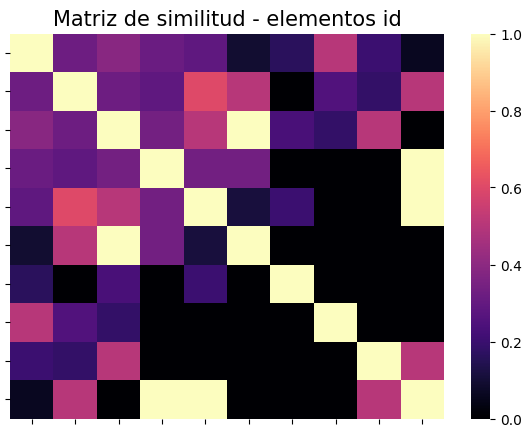

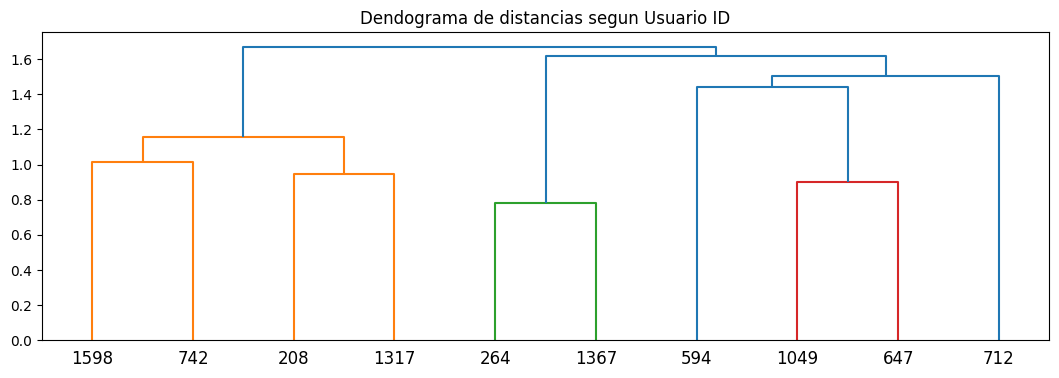

1049      1317      1367      1598       208       264       594  \
1049  1.000000  0.323529  0.389706  0.312500  0.288889  0.090909  0.162162   
1317  0.323529  1.000000  0.322034  0.285714  0.600000  0.500000  0.000000   
1367  0.389706  0.322034  1.000000  0.339286  0.500000  1.000000  0.233333   
1598  0.312500  0.285714  0.339286  1.000000  0.333333  0.333333  0.000000   
208   0.288889  0.600000  0.500000  0.333333  1.000000  0.111111  0.200000   
264   0.090909  0.500000  1.000000  0.333333  0.111111  1.000000  0.000000   
594   0.162162  0.000000  0.233333  0.000000  0.200000  0.000000  1.000000   
647   0.500000  0.250000  0.181818  0.000000  0.000000  0.000000  0.000000   
712   0.200000  0.181818  0.500000  0.000000  0.000000  0.000000  0.000000   
742   0.058824  0.500000  0.000000  1.000000  1.000000  0.000000  0.000000   

           647       712       742 grupo  
1049  0.500000  0.200000  0.058824    C3  
1317  0.250000  0.181818  0.500000    C1  
1367  0.181818  0.500000  0.000000    C2  
1598  0.000000  0.000000  1.000000    C1  
208   0.000000  0.000000  1.000000    C1  
264   0.000000  0.000000  0.000000    C2  
594   0.000000  0.000000  0.000000    C0  
647   1.000000  0.000000  0.000000    C3  
712   0.000000  1.000000  0.500000    C0  
742   0.000000  0.500000  1.000000    C1

In [119]:
# (Opcion 2) Algoritmo de factorizacion de matriz SVD

opcion_uso = "SVD"

#########################

# Definir algoritmo
modelo = SVD(
    n_epochs = 100,
    biased = True,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "elementos id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Cantidad de factores segun modelo entrenado: 15
RMSE:  1.276
MSE :  1.629
MAE :  1.038
-----------------------------------------
Opcion de uso: NMF
Tipo similitud basado en usuario [1:si;0:no]:  True


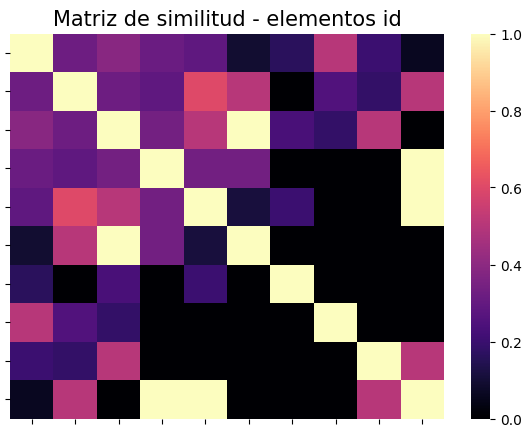

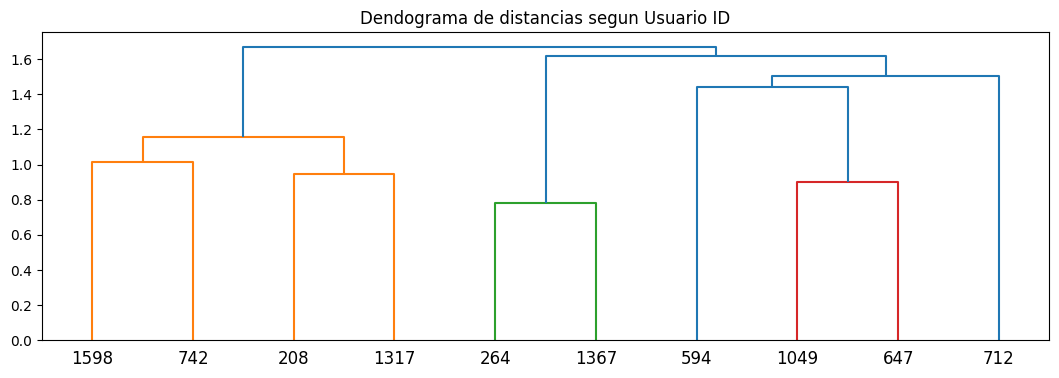

1049      1317      1367      1598       208       264       594  \
1049  1.000000  0.323529  0.389706  0.312500  0.288889  0.090909  0.162162   
1317  0.323529  1.000000  0.322034  0.285714  0.600000  0.500000  0.000000   
1367  0.389706  0.322034  1.000000  0.339286  0.500000  1.000000  0.233333   
1598  0.312500  0.285714  0.339286  1.000000  0.333333  0.333333  0.000000   
208   0.288889  0.600000  0.500000  0.333333  1.000000  0.111111  0.200000   
264   0.090909  0.500000  1.000000  0.333333  0.111111  1.000000  0.000000   
594   0.162162  0.000000  0.233333  0.000000  0.200000  0.000000  1.000000   
647   0.500000  0.250000  0.181818  0.000000  0.000000  0.000000  0.000000   
712   0.200000  0.181818  0.500000  0.000000  0.000000  0.000000  0.000000   
742   0.058824  0.500000  0.000000  1.000000  1.000000  0.000000  0.000000   

           647       712       742 grupo  
1049  0.500000  0.200000  0.058824    C3  
1317  0.250000  0.181818  0.500000    C1  
1367  0.181818  0.500000  0.000000    C2  
1598  0.000000  0.000000  1.000000    C1  
208   0.000000  0.000000  1.000000    C1  
264   0.000000  0.000000  0.000000    C2  
594   0.000000  0.000000  0.000000    C0  
647   1.000000  0.000000  0.000000    C3  
712   0.000000  1.000000  0.500000    C0  
742   0.000000  0.500000  1.000000    C1

In [47]:
# (Opcion 3) Algoritmo de recomendacion por factorizacion de matriz NMF

opcion_uso = "NMF"

########################
## Definir modelo

### Seleccion de modelo
modelo = NMF(
    n_epochs = 100,
    biased = False,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

#########################
# Predicciones

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

###################################
# Visualizar matriz de similitud

# aspectos figura
figx = 7
figy = 5

# tipo grafica
tipo = "elementos id"

# data
data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# rangos similitud
sim_min = data_pivot.min().min()
sim_max = data_pivot.max().max()

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
ax.set_xlabel("", fontsize = 13)
ax.set_ylabel("", fontsize = 13)
#ax.set_yticklabels(ax.get_yticks(),size=10)
#ax.set_xticklabels(ax.get_xticks(),size=10)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

#########################

# Dendograma segun matriz de similitud
nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
plt.title('Dendograma de distancias segun Usuario ID')
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in data_pivot.index):
        data_pivot.loc[elem,"grupo"] = grupo

##########################

# ver dataframe
data_pivot

Ver predicciones de entrenamiento

In [120]:
# Prediccion con datos Test y evaluacion de rendimiento
predicciones

[Prediction(uid='742', iid='895', r_ui=4.0, est=3.6195761673404654, details={'was_impossible': False}),
 Prediction(uid='264', iid='551', r_ui=3.0, est=3.0326664283916425, details={'was_impossible': False}),
 Prediction(uid='264', iid='76', r_ui=3.0, est=2.8372176800234388, details={'was_impossible': False}),
 Prediction(uid='742', iid='763', r_ui=4.0, est=3.6195761673404654, details={'was_impossible': False}),
 Prediction(uid='208', iid='158', r_ui=5.0, est=4.22625875382986, details={'was_impossible': False}),
 Prediction(uid='208', iid='299', r_ui=4.0, est=3.7470260284594428, details={'was_impossible': False}),
 Prediction(uid='208', iid='380', r_ui=2.0, est=3.922510934019966, details={'was_impossible': False}),
 Prediction(uid='647', iid='269', r_ui=4.0, est=4.092530719567613, details={'was_impossible': False}),
 Prediction(uid='1049', iid='796', r_ui=4.0, est=2.605805427453629, details={'was_impossible': False}),
 Prediction(uid='742', iid='189', r_ui=3.0, est=3.67109170701237, det

Predicciones con valores ingresados

In [114]:
# lista items seleccionados - Ojo este es el verdadero valor de "item id"
valores_user

['1049', '1317', '1367', '1598', '208', '264', '594', '647', '712', '742']

In [115]:
# lista users seleccionados - Ojo este es el verdadero valor de "usuarios id"
valores_item[:10]  # solo mostrar algunos

['130', '159', '181', '200', '203', '207', '280', '374', '393', '42']

In [116]:
# Prediccion personalizadas (ingreso de datos a predecir)

# Usuari & Item a predecir - Ojo aqui no invertir nombres, colocar el verdadero valor de user y item
user_id = [119,119,125,125]
item_id = [105,135,1121,186]

# Recorre cada par (item_id,user_id), en caso se tiene el valor de puntaje real indicar en "r_ui" (real rating)
for user,item in zip(item_id,user_id):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 105        item: 119        r_ui = None   est = 3.74   {'was_impossible': False}
user: 135        item: 119        r_ui = None   est = 3.74   {'was_impossible': False}
user: 1121       item: 125        r_ui = None   est = 3.42   {'was_impossible': False}
user: 186        item: 125        r_ui = None   est = 3.42   {'was_impossible': False}


Analisis descriptivo de datos

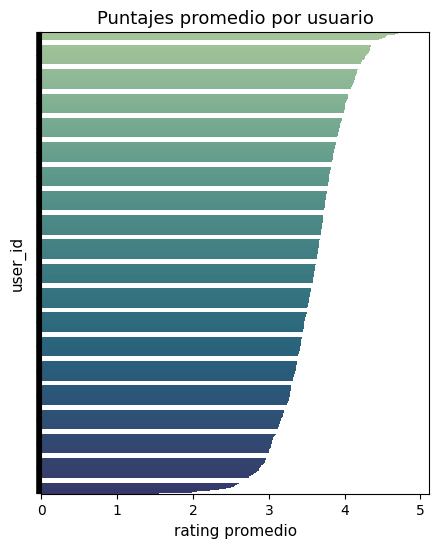

user_id  rating_mean  rating_std  cuenta
832     849     4.869565    0.344350      23
653     688     4.833333    0.637022      24
453     507     4.724138    0.767614      58
587     628     4.703704    0.724028      27
920     928     4.687500    0.692704      32
..      ...          ...         ...     ...
749     774     2.058036    1.140855     224
650     685     2.050000    0.759155      20
384     445     1.992481    1.104373     133
340     405     1.898960    1.381817     673
91      181     1.544529    0.874046     393

[943 rows x 4 columns]

In [110]:
# Ver tabla de usuarios - mayor rating

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="user_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por usuario", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

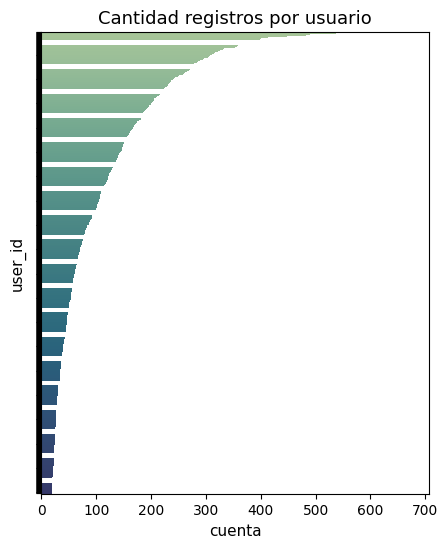

user_id  rating_mean  rating_std  cuenta
340     405     1.898960    1.381817     673
617     655     2.899687    0.734419     638
34       13     3.125000    1.405247     624
390     450     3.868030    0.862665     538
196     276     3.467054    1.016791     516
..      ...          ...         ...     ...
115     202     2.800000    1.281447      20
851     866     2.700000    1.031095      20
805     824     2.600000    0.940325      20
650     685     2.050000    0.759155      20
159     242     4.421053    0.768533      19

[943 rows x 4 columns]

In [111]:
# Ver tabla de usuarios - mayor cantidad registros

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="user_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por usuario", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

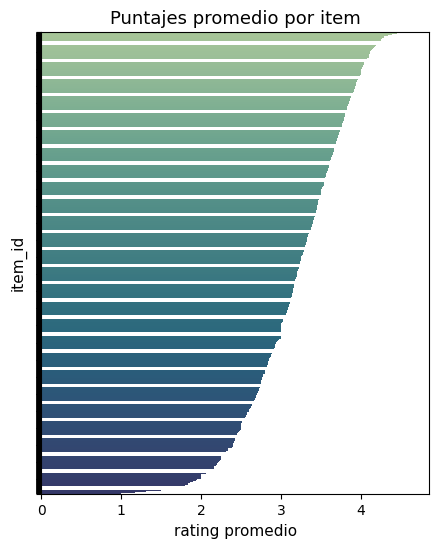

item_id  rating_mean  rating_std  cuenta
418     1449     4.625000    0.517549       8
200      119     4.500000    1.000000       4
774      408     4.491071    0.771047     112
674      318     4.466443    0.829109     298
508      169     4.466102    0.823607     118
...      ...          ...         ...     ...
1179     777     1.250000    0.500000       4
807      438     1.166667    0.408248       6
670      314     1.000000    0.000000       5
806      437     1.000000    0.000000       5
808      439     1.000000    0.000000       5

[1413 rows x 4 columns]

In [112]:
# Ver tabla de items - mayor rating

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="item_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por item", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

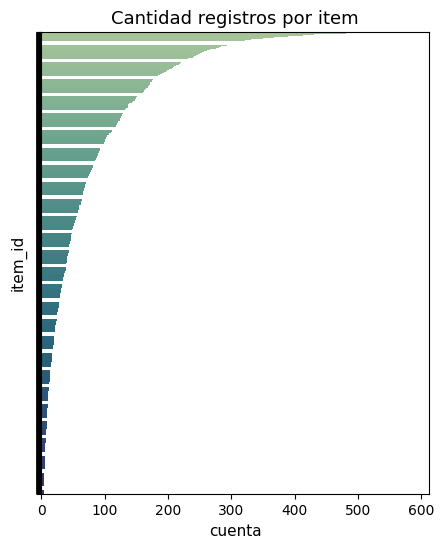

item_id  rating_mean  rating_std  cuenta
876       50     4.358491    0.881341     583
607      258     3.803536    0.994427     509
2        100     4.155512    0.975756     508
522      181     4.007890    0.923955     507
647      294     3.156701    1.098544     485
...      ...          ...         ...     ...
269     1257     1.750000    0.957427       4
328     1319     1.750000    0.957427       4
471     1539     1.750000    0.500000       4
812      442     1.250000    0.500000       4
1179     777     1.250000    0.500000       4

[1413 rows x 4 columns]

In [113]:
# Ver tabla de items - mayor cantidad registros

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="item_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por item", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

Ejemplo aplicación de algoritmo entrenado en usuario y item

In [121]:
# Seleccionar aleatoriamente un usuario y item (Ojo cuidado que estan invertidos desde origen)

val_item = random.sample(valores_item,1)
val_user = random.sample(valores_user,1)

print('User:',val_item)
print('Item:',val_user)

User: ['421']
Item: ['264']


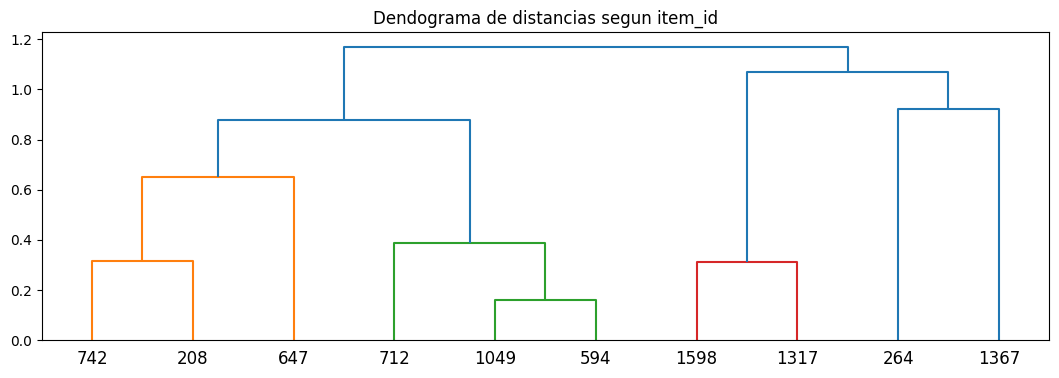

item_id   similar  cuenta  rating_mean  rating_std grupo
item_id                                                         
1367       1367  1.000000       5     4.200000    1.303840    C0
264         264  1.000000     101     2.742574    0.912726    C0
1317       1317  0.500000       4     2.000000    1.414214    C3
1598       1598  0.333333       6     2.500000    1.516575    C3
208         208  0.111111     200     3.945000    0.903358    C1
1049       1049  0.090909      25     2.520000    0.962635    C2
594         594  0.000000       5     2.400000    0.894427    C2
647         647  0.000000      70     4.100000    0.980240    C1
712         712  0.000000      51     3.078431    0.770536    C2
742         742  0.000000     267     3.644195    0.948284    C1

In [122]:
# Ranking de usuarios similares para el item seleccionado (ordenado de mayor a menor)

tipo_ref = "item_id"

valor = val_user[0]
similar = pd.DataFrame(data_pivot[valor].sort_values(ascending=False)).reset_index().rename(columns={valor:"similar","index":tipo_ref})
#similar = similar[similar[tipo_ref] != valor].copy()
similar = similar.merge(item_kpi,how="inner",on=tipo_ref)
similar.sort_values(["similar","rating_mean","rating_std","cuenta"],ascending=False)
similar.index = similar[tipo_ref]

###################

# Seleccionar variables a usar para dendograma
etiquetas = similar[tipo_ref].tolist()
df_dist = similar[["similar","rating_mean","rating_std","cuenta"]].copy()

# Normalizar variables para calculo de distancias
df_dist.rating_mean = (df_dist.rating_mean - df_dist.rating_mean.min())/(df_dist.rating_mean.max() - df_dist.rating_mean.min())
df_dist.rating_std = (df_dist.rating_std - df_dist.rating_std.min())/(df_dist.rating_std.max() - df_dist.rating_std.min())
df_dist.similar = (df_dist.similar - df_dist.similar.min())/(df_dist.similar.max() - df_dist.similar.min())
df_dist.cuenta = (df_dist.cuenta - df_dist.cuenta.min())/(df_dist.cuenta.max() - df_dist.cuenta.min())

# Dendograma segun distancias calculadas
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(pdist(df_dist,'euclidean'), 'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=5,labels=etiquetas)
plt.title('Dendograma de distancias segun ' + str(tipo_ref))
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in similar.index):
        similar.loc[elem,"grupo"] = grupo
        
###################

similar

In [123]:
# Recorre cada par (item_id,user_id) y calcular rating asignado ... (Ojo cuidado que esta invertido el print!!!)

for user,item in zip(val_user,val_item):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print("[Invertir item & user] :: ",predice)

[Invertir item & user] ::  user: 264        item: 421        r_ui = None   est = 2.52   {'was_impossible': False}


## 3.4. Opcion de seleccion de todos elementos (item)

In [124]:
# Indicar cantidad minima de registros por cada tipo

# Aqui como se escoge por elementos (item), se debe filtrar segun item y no por usuario
min_reg_user = 1
min_reg_item = 4

print('Valor minimo de registros por user:',min_reg_user)
print('Valor minimo de registros por item:',min_reg_item)

Valor minimo de registros por user: 1
Valor minimo de registros por item: 4


In [125]:
# Cargar datos y seleccionar todos items (Cuidado que se invierte el orden de columnas "item_id" y "user_id")

## Datasets disponibles: "movielens-100k", "movielens-1m" , "Jester"
dataset = "ml-100k"

# Setear semilla para reproducibilidad
random.seed(123)

##############################
# Cargar datos

data = Dataset.load_builtin(dataset)

# convertir a dataframe
data_df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])[["user_id","item_id","rating"]]
data_df_copy = data_df.copy() # copia de dataframe original, dado que se va transformar

# Eliminar duplicados
data_df = data_df.groupby(["user_id","item_id"]).agg(np.median).reset_index()
data_df["rating"] = pd.to_numeric(data_df["rating"],errors="coerce",downcast="integer")

##############################
# Filtrar registros segun umbrales minimos de registros (user & item)

item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})

#####

lista_item_remueve = item_cuenta[item_cuenta.cuenta < min_reg_item]["item_id"].tolist()
lista_user_remueve = user_cuenta[user_cuenta.cuenta < min_reg_user]["user_id"].tolist()

# Remover elementos con cantidad inferiores al umbral minimo
n_inicio = data_df.shape[0]
data_df = data_df[~data_df.user_id.isin(lista_user_remueve)].copy()
data_df = data_df[~data_df.item_id.isin(lista_item_remueve)].copy()
n_final = data_df.shape[0]

print('-------------------------------------')
print('Cantidad registros :: inicio:',n_inicio,' ; final:',n_final,' ; diferencia:',n_inicio-n_final,' - equiv.(%):',np.round(100.0*(n_final/n_inicio),1))
print('-------------------------------------')


# Calcular de nuevo KPI's luego de filtrado 
item_cuenta = pd.DataFrame(data_df[["item_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
item_rating = pd.DataFrame(data_df[["item_id","rating"]].groupby("item_id").agg([np.mean,np.std])).reset_index()
item_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in item_rating.columns]
item_rating.fillna(0,inplace=True) 

user_cuenta = pd.DataFrame(data_df[["user_id"]].value_counts()).reset_index().rename(columns={0:"cuenta"})
user_rating = pd.DataFrame(data_df[["user_id","rating"]].groupby("user_id").agg([np.mean,np.std])).reset_index()
user_rating.columns = ['_'.join(col) if not('_'.join(col).endswith("_")) else col[0] for col in user_rating.columns]
user_rating.fillna(0,inplace=True) 

item_kpi = item_cuenta.merge(item_rating,how="inner",on="item_id")
user_kpi = user_cuenta.merge(user_rating,how="inner",on="user_id")


###############################
###############################
# Invertir orden de columnas

## user_id* => item_id
## item_id* => user_id

# Aplicar inversion de columnas
data_df[["user_id","item_id"]] = data_df[["item_id","user_id"]].values.copy()

###############################
##############################


# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista de items
user_ids = data_df.sort_values("user_id").user_id.unique().tolist()

n_items = len(user_ids)

# seleccionar ID de los elementos
print('Cantidad de elementos: ',n_items)
data_df = data_df[data_df.user_id.isin(user_ids)]

# Ordenar los datos
data_df = data_df.sort_values(["user_id","item_id"])

# lista valores
valores_user = data_df.user_id.unique().tolist()
valores_item = data_df.item_id.unique().tolist()

data_df

-------------------------------------
Cantidad registros :: inicio: 100000  ; final: 99543  ; diferencia: 457  - equiv.(%): 99.5
-------------------------------------
Cantidad de elementos:  1413


user_id item_id  rating
0           1       1       5
272         1      10       4
515         1     101       3
582         1     102       3
961         1     106       4
...       ...     ...     ...
39824     999     417       3
40059     999      42       4
41167     999     429       2
47165     999     476       2
70987     999     682       2

[99543 rows x 3 columns]

In [126]:
# Ver tabla en formato de recomendacion

pd.pivot_table(data_df.rename(columns={"user_id":"item_id","item_id":"user_id"},inplace=False),
    index='user_id', columns='item_id', values='rating', aggfunc='median').fillna("")

item_id    1   10  100 1000 1001 1002 1003 1004 1005 1006  ...  990 991 992  \
user_id                                                    ...                
1        5.0  3.0  5.0                                     ...                
10       4.0       5.0                                     ...                
100                                                        ...  3.0           
101      3.0                                               ...                
102      3.0                                               ...                
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..   
95       5.0                                               ...                
96       5.0       5.0                                     ...                
97       4.0       2.0                                     ...                
98                                                         ...                
99       4.0       5.0                                     ...                

item_id  993 994 995 996 997 998 999  
user_id                               
1                                     
10                                    
100                                   
101                                   
102      2.0                          
...      ...  ..  ..  ..  ..  ..  ..  
95                                    
96                                    
97                                    
98                                    
99                                    

[943 rows x 1413 columns]

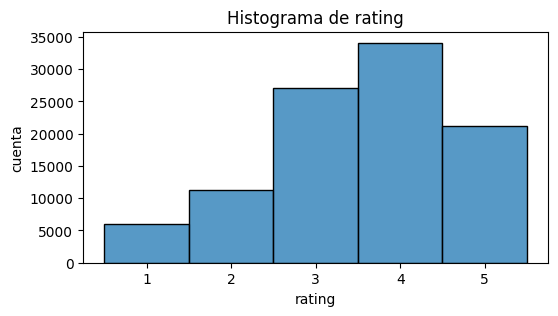

In [127]:
# histograma de ratings

plt.figure(figsize=(6,3))
sns.histplot(data=data_df,x="rating",discrete=True,stat="count")
plt.title('Histograma de rating')
plt.ylabel("cuenta")
plt.show()

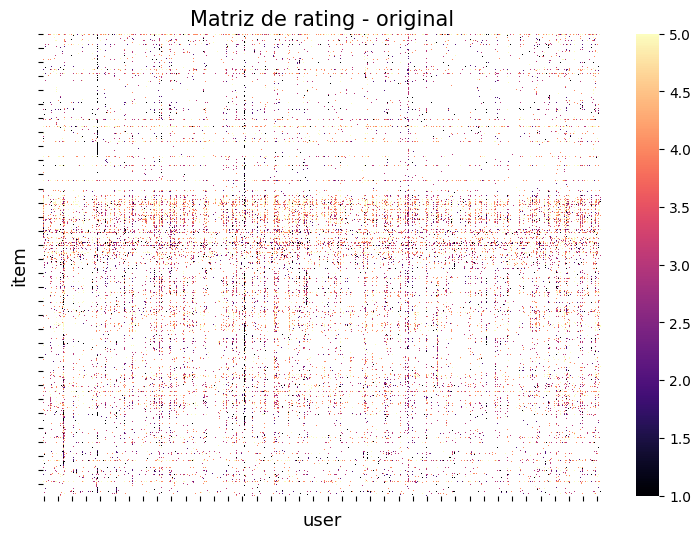

In [128]:
# Visualizar datos de rating

# rangos rating
rating_min = 1
rating_max = 5

# aspectos figura
figx = 9
figy = 6

# data
data_pivot = pd.pivot_table(data_df,index='user_id', columns='item_id', values='rating', aggfunc='median')
nombres = [str(ii) for ii in range(data_pivot.shape[0])]

# figure
fig, ax = plt.subplots(figsize=(figx,figy))
sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=rating_min,vmax=rating_max)
ax.set_title("Matriz de rating - original", fontsize = 15)
ax.set_xlabel('user', fontsize = 13)
ax.set_ylabel('item', fontsize = 13)
ax.set_yticklabels("", size = 0)
ax.set_xticklabels("", size = 0)
plt.show()

In [129]:
# Transformar datos - Train/Test

# Indicar rango de puntajes
reader = Reader(rating_scale=(1, 5))

# Convertir a formato indicando rango de valores para el puntaje
data_df = Dataset.load_from_df(data_df[["user_id", "item_id", "rating"]], reader)

########################

# Generar particion en Train-Test
test_porcentaje = 0.15
trainset, testset = train_test_split(data_df, test_size=test_porcentaje,random_state=123)

Algoritmo de aprendizaje

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE:  1.02
MSE :  1.04
MAE :  0.804
-----------------------------------------
Opcion de uso: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the cosine similarity matrix...
Done computing similarity matrix.


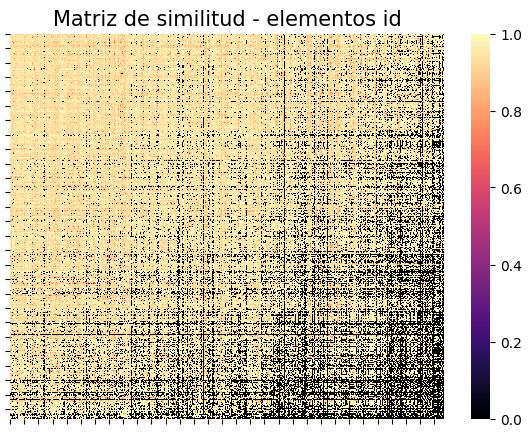

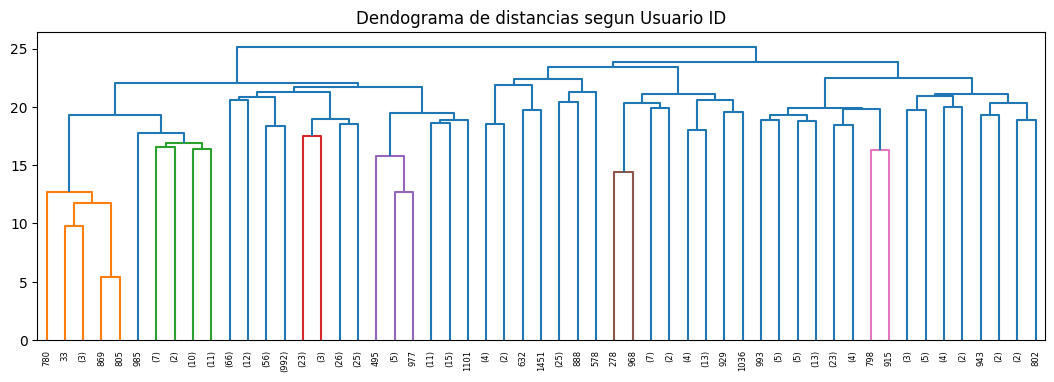

In [56]:
# (Opcion 1 - sim:cosine) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "cosine",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

try:
    ###################################
    # Visualizar matriz de similitud

    # aspectos figura
    figx = 7
    figy = 5

    # tipo grafica
    tipo = "elementos id"

    # data
    data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
    nombres = [str(ii) for ii in range(data_pivot.shape[0])]

    # rangos similitud
    sim_min = data_pivot.min().min()
    sim_max = data_pivot.max().max()

    # figure
    fig, ax = plt.subplots(figsize=(figx,figy))
    sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
    ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
    ax.set_xlabel("", fontsize = 13)
    ax.set_ylabel("", fontsize = 13)
    #ax.set_yticklabels(ax.get_yticks(),size=10)
    #ax.set_xticklabels(ax.get_xticks(),size=10)
    ax.set_yticklabels("", size = 0)
    ax.set_xticklabels("", size = 0)
    plt.show()

    #########################

    # Dendograma segun matriz de similitud
    nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
    fig = plt.figure(figsize=(13,4))
    Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
    dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
    plt.title('Dendograma de distancias segun Usuario ID')
    plt.show()

    # asignar grupo segun dendograma
    for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
        if(elem in data_pivot.index):
            data_pivot.loc[elem,"grupo"] = grupo

    ##########################
    
    # ver dataframe
    data_pivot

except:
    print('No se pudo calcular la matriz de similitud')

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE:  0.966
MSE :  0.933
MAE :  0.763
-----------------------------------------
Opcion de uso: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the msd similarity matrix...
Done computing similarity matrix.


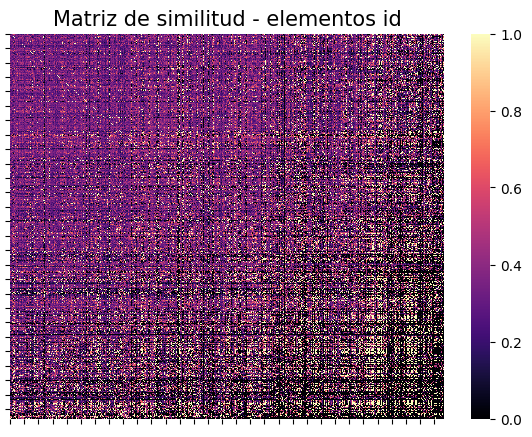

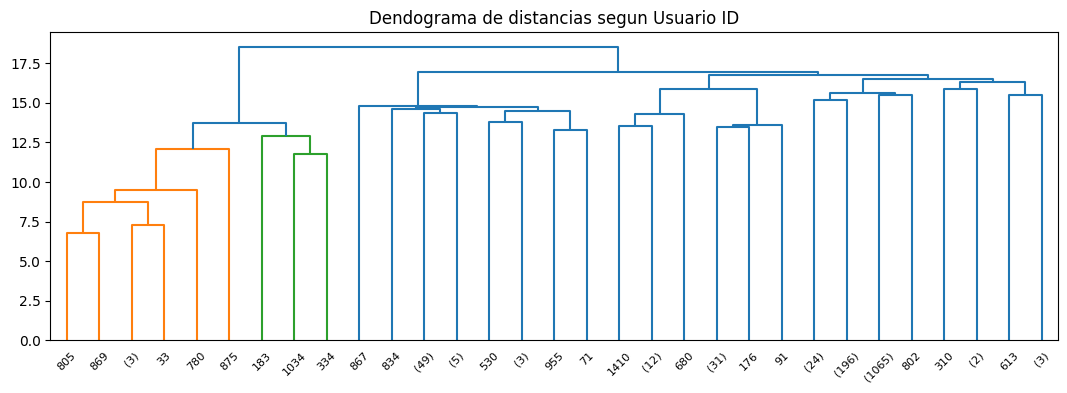

In [57]:
# (Opcion 1 - sim:msd) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "msd",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

try:
    ###################################
    # Visualizar matriz de similitud

    # aspectos figura
    figx = 7
    figy = 5

    # tipo grafica
    tipo = "elementos id"

    # data
    data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
    nombres = [str(ii) for ii in range(data_pivot.shape[0])]

    # rangos similitud
    sim_min = data_pivot.min().min()
    sim_max = data_pivot.max().max()

    # figure
    fig, ax = plt.subplots(figsize=(figx,figy))
    sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
    ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
    ax.set_xlabel("", fontsize = 13)
    ax.set_ylabel("", fontsize = 13)
    #ax.set_yticklabels(ax.get_yticks(),size=10)
    #ax.set_xticklabels(ax.get_xticks(),size=10)
    ax.set_yticklabels("", size = 0)
    ax.set_xticklabels("", size = 0)
    plt.show()
    
    #########################

    # Dendograma segun matriz de similitud
    nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
    fig = plt.figure(figsize=(13,4))
    Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
    dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
    plt.title('Dendograma de distancias segun Usuario ID')
    plt.show()

    # asignar grupo segun dendograma
    for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
        if(elem in data_pivot.index):
            data_pivot.loc[elem,"grupo"] = grupo

    ##########################

    # ver dataframe
    data_pivot

except:
    print('No se pudo calcular la matriz de similitud')

Similitud entre usuarios [1:Si, 0:No]: 1
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE:  1.03
MSE :  1.061
MAE :  0.825
-----------------------------------------
Opcion de uso: KNN
Tipo similitud basado en usuario [1:si;0:no]:  True
Computing the pearson similarity matrix...
Done computing similarity matrix.


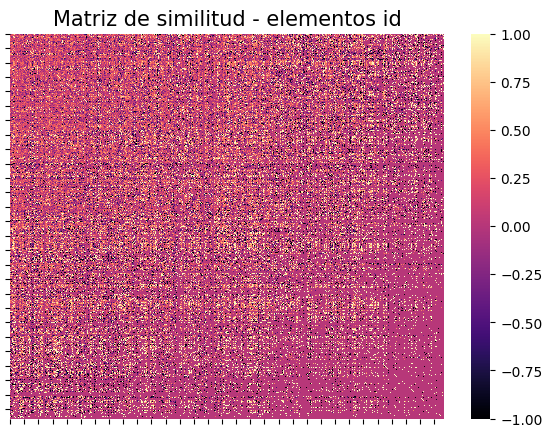

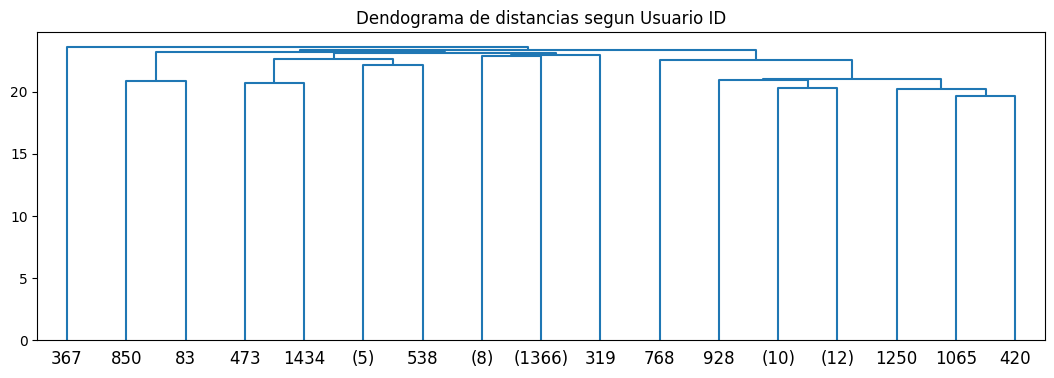

In [58]:
# (Opcion 1 - sim:pearson) Algoritmo por vecindad KNN

opcion_uso = "KNN"

########################
## Definir modelo

# La comparacion de similitud se realiza entre usuarios o entre elementos
user_based = True  # True: entre usuarios, False: entre elementos

# Cantidad de vecinos a tomar en cuenta
min_k = 2

print('Similitud entre usuarios [1:Si, 0:No]:',user_based*1)

bsl_options = {
    "method": "als",
    "n_epochs": 100,
    "learning_rate": 1e-4,
    "reg_u": 1,
    "reg_i": 2
}

sim_options = {
    "name": "pearson",
    "user_based": user_based  # calcular similitud entre usuarios o elementos
}

### Seleccion de modelo
modelo = KNNBasic(bsl_options=bsl_options,sim_options=sim_options,min_k=min_k,verbose=1) 

# Ajustar segun datos Train
modelo.fit(trainset)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

try:
    ###################################
    # Visualizar matriz de similitud

    # aspectos figura
    figx = 7
    figy = 5

    # tipo grafica
    tipo = "elementos id"

    # data
    data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
    nombres = [str(ii) for ii in range(data_pivot.shape[0])]

    # rangos similitud
    sim_min = data_pivot.min().min()
    sim_max = data_pivot.max().max()

    # figure
    fig, ax = plt.subplots(figsize=(figx,figy))
    sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
    ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
    ax.set_xlabel("", fontsize = 13)
    ax.set_ylabel("", fontsize = 13)
    #ax.set_yticklabels(ax.get_yticks(),size=10)
    #ax.set_xticklabels(ax.get_xticks(),size=10)
    ax.set_yticklabels("", size = 0)
    ax.set_xticklabels("", size = 0)
    plt.show()
    
    #########################

    # Dendograma segun matriz de similitud
    nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
    fig = plt.figure(figsize=(13,4))
    Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
    dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
    plt.title('Dendograma de distancias segun Usuario ID')
    plt.show()

    # asignar grupo segun dendograma
    for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
        if(elem in data_pivot.index):
            data_pivot.loc[elem,"grupo"] = grupo

    ##########################

    # ver dataframe
    data_pivot

except:
    print('No se pudo calcular la matriz de similitud')

Cantidad de factores segun modelo entrenado: 100
RMSE:  0.971
MSE :  0.943
MAE :  0.763
-----------------------------------------
Opcion de uso: SVD
Tipo similitud basado en usuario [1:si;0:no]:  True


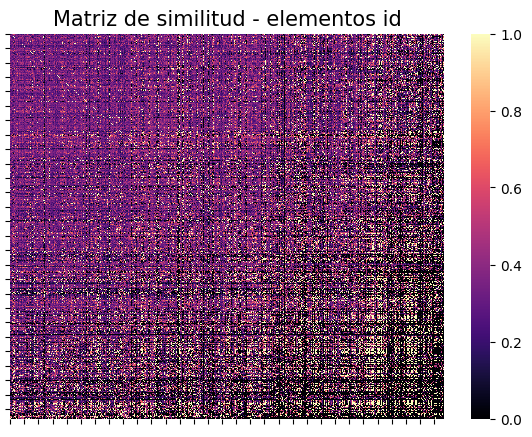

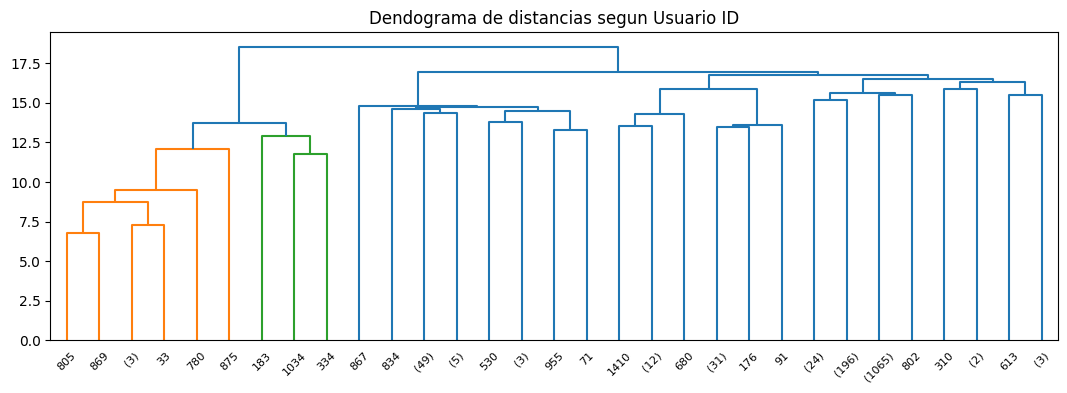

In [130]:
# (Opcion 2) Algoritmo de factorizacion de matriz SVD

opcion_uso = "SVD"

#########################

# Definir algoritmo
modelo = SVD(
    n_epochs = 100,
    biased = True,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

########################

# Prediccion con datos Test y evaluacion de rendimiento
predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

try:
    ###################################
    # Visualizar matriz de similitud

    # aspectos figura
    figx = 7
    figy = 5

    # tipo grafica
    tipo = "elementos id"

    # data
    data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
    nombres = [str(ii) for ii in range(data_pivot.shape[0])]

    # rangos similitud
    sim_min = data_pivot.min().min()
    sim_max = data_pivot.max().max()

    # figure
    fig, ax = plt.subplots(figsize=(figx,figy))
    sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
    ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
    ax.set_xlabel("", fontsize = 13)
    ax.set_ylabel("", fontsize = 13)
    #ax.set_yticklabels(ax.get_yticks(),size=10)
    #ax.set_xticklabels(ax.get_xticks(),size=10)
    ax.set_yticklabels("", size = 0)
    ax.set_xticklabels("", size = 0)
    plt.show()
    
    #########################

    # Dendograma segun matriz de similitud
    nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
    fig = plt.figure(figsize=(13,4))
    Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
    dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
    plt.title('Dendograma de distancias segun Usuario ID')
    plt.show()

    # asignar grupo segun dendograma
    for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
        if(elem in data_pivot.index):
            data_pivot.loc[elem,"grupo"] = grupo

    ##########################
    
    # ver dataframe
    data_pivot

except:
    print('No se pudo calcular la matriz de similitud')

Cantidad de factores segun modelo entrenado: 15
RMSE:  0.944
MSE :  0.892
MAE :  0.741
-----------------------------------------
Opcion de uso: NMF
Tipo similitud basado en usuario [1:si;0:no]:  True


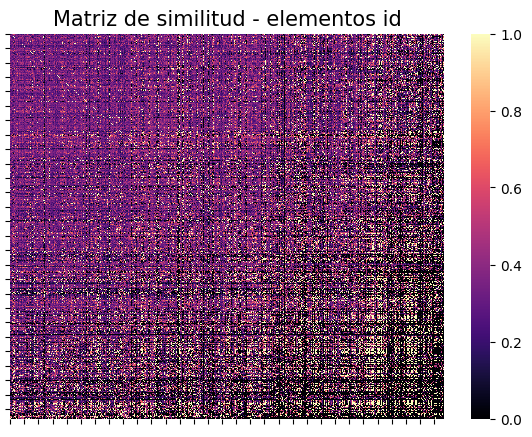

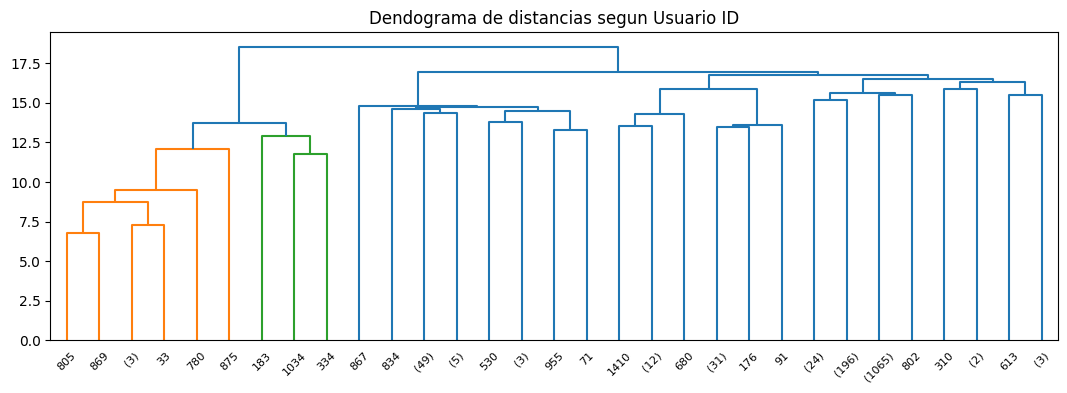

In [60]:
# (Opcion 3) Algoritmo de recomendacion por factorizacion de matriz NMF

opcion_uso = "NMF"

########################
## Definir modelo

### Seleccion de modelo
modelo = NMF(
    n_epochs = 100,
    biased = False,
    random_state = 123,
    verbose = False
)

########################

# Ajustar segun datos Train
modelo.fit(trainset)

# Informativo
print('Cantidad de factores segun modelo entrenado:',modelo.n_factors)

#########################
# Predicciones

predicciones = modelo.test(testset)

# Calcular rendimiento de modelo
print("RMSE: ",np.round(accuracy.rmse(predicciones,verbose=0),3))
print("MSE : ",np.round(accuracy.mse(predicciones,verbose=0),3))
print("MAE : ",np.round(accuracy.mae(predicciones,verbose=0),3))

############################
############################
# Matriz de similitud entre usuarios "user_id" : (userd_id vs user_id)

print('-----------------------------------------')
print('Opcion de uso:',opcion_uso)
print('Tipo similitud basado en usuario [1:si;0:no]: ',modelo.sim_options['user_based'])

# valores entre pares
if(modelo.sim_options['user_based']):
    valores = valores_user
else:
    valores = valores_item

try:
    ###################################
    # Visualizar matriz de similitud

    # aspectos figura
    figx = 7
    figy = 5

    # tipo grafica
    tipo = "elementos id"

    # data
    data_pivot = pd.DataFrame(data=modelo.compute_similarities(),columns=valores,index=valores)
    nombres = [str(ii) for ii in range(data_pivot.shape[0])]

    # rangos similitud
    sim_min = data_pivot.min().min()
    sim_max = data_pivot.max().max()

    # figure
    fig, ax = plt.subplots(figsize=(figx,figy))
    sns.heatmap(data_pivot,cmap="magma",ax=ax,vmin=sim_min,vmax=sim_max)
    ax.set_title("Matriz de similitud - " + str(tipo), fontsize = 15)
    ax.set_xlabel("", fontsize = 13)
    ax.set_ylabel("", fontsize = 13)
    #ax.set_yticklabels(ax.get_yticks(),size=10)
    #ax.set_xticklabels(ax.get_xticks(),size=10)
    ax.set_yticklabels("", size = 0)
    ax.set_xticklabels("", size = 0)
    plt.show()
    
    #########################

    # Dendograma segun matriz de similitud
    nivel_dendograma = 5  # cantidad de niveles a considerar en corte de dendograma
    fig = plt.figure(figsize=(13,4))
    Z = hierarchy.linkage(data_pivot,'average',optimal_ordering=True)
    dn = dendrogram(Z,truncate_mode="level",p=nivel_dendograma,labels=data_pivot.columns.tolist())
    plt.title('Dendograma de distancias segun Usuario ID')
    plt.show()

    # asignar grupo segun dendograma
    for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
        if(elem in data_pivot.index):
            data_pivot.loc[elem,"grupo"] = grupo

    ##########################
    
    # ver dataframe
    data_pivot

except:
    print('No se pudo calcular la matriz de similitud')

Predicciones con valores ingresados

In [133]:
# lista items seleccionados - Ojo este es el verdadero valor de "item id" - solo primeros valores
valores_user[:10]

['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006']

In [134]:
# lista users seleccionados - Ojo este es el verdadero valor de "usuarios id" - solo primeros valores
valores_item[:10]

['1', '10', '101', '102', '106', '108', '109', '117', '120', '121']

In [124]:
# Prediccion personalizadas (ingreso de datos a predecir)

# Usuari & Item a predecir - Ojo aqui no invertir nombres, colocar el verdadero valor de user y item
user_id = [1,10,101,102]
item_id = [1,10,100,1000]

# Recorre cada par (item_id,user_id), en caso se tiene el valor de puntaje real indicar en "r_ui" (real rating)
for user,item in zip(item_id,user_id):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print(predice)

user: 1          item: 1          r_ui = None   est = 4.12   {'was_impossible': False}
user: 10         item: 10         r_ui = None   est = 4.22   {'was_impossible': False}
user: 100        item: 101        r_ui = None   est = 4.30   {'was_impossible': False}
user: 1000       item: 102        r_ui = None   est = 2.59   {'was_impossible': False}


Analisis descriptivo de datos

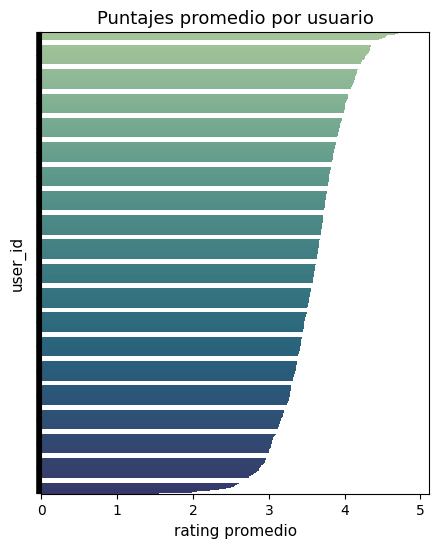

user_id  rating_mean  rating_std  cuenta
832     849     4.869565    0.344350      23
653     688     4.833333    0.637022      24
453     507     4.724138    0.767614      58
587     628     4.703704    0.724028      27
920     928     4.687500    0.692704      32
..      ...          ...         ...     ...
749     774     2.058036    1.140855     224
650     685     2.050000    0.759155      20
384     445     1.992481    1.104373     133
340     405     1.898960    1.381817     673
91      181     1.544529    0.874046     393

[943 rows x 4 columns]

In [125]:
# Ver tabla de usuarios - mayor rating

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="user_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por usuario", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

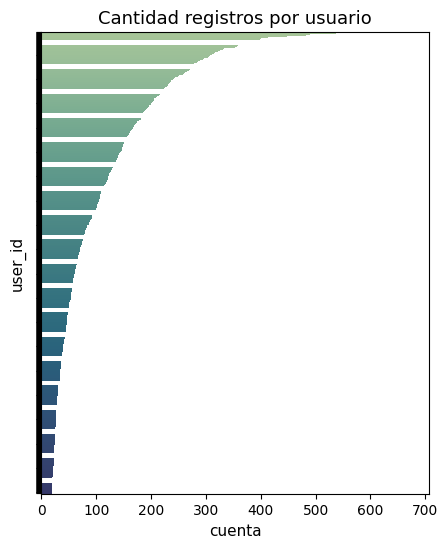

user_id  rating_mean  rating_std  cuenta
340     405     1.898960    1.381817     673
617     655     2.899687    0.734419     638
34       13     3.125000    1.405247     624
390     450     3.868030    0.862665     538
196     276     3.467054    1.016791     516
..      ...          ...         ...     ...
115     202     2.800000    1.281447      20
851     866     2.700000    1.031095      20
805     824     2.600000    0.940325      20
650     685     2.050000    0.759155      20
159     242     4.421053    0.768533      19

[943 rows x 4 columns]

In [126]:
# Ver tabla de usuarios - mayor cantidad registros

dfp = user_rating.merge(user_cuenta,how="inner",on="user_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="user_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por usuario", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('user_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

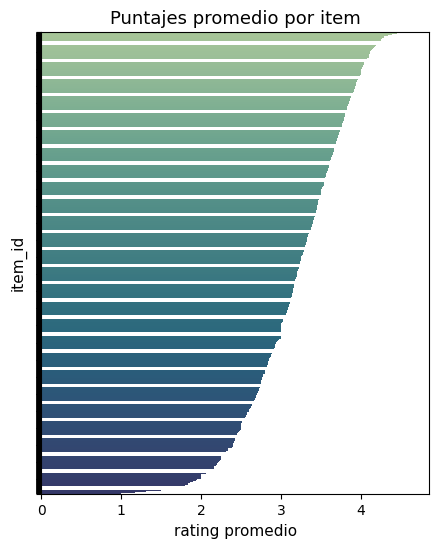

item_id  rating_mean  rating_std  cuenta
418     1449     4.625000    0.517549       8
200      119     4.500000    1.000000       4
774      408     4.491071    0.771047     112
674      318     4.466443    0.829109     298
508      169     4.466102    0.823607     118
...      ...          ...         ...     ...
1179     777     1.250000    0.500000       4
807      438     1.166667    0.408248       6
670      314     1.000000    0.000000       5
806      437     1.000000    0.000000       5
808      439     1.000000    0.000000       5

[1413 rows x 4 columns]

In [127]:
# Ver tabla de items - mayor rating

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["rating_mean","cuenta"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="rating_mean",y="item_id",ax=ax, palette="crest")
ax.set_title("Puntajes promedio por item", fontsize = 13)
ax.set_xlabel('rating promedio', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

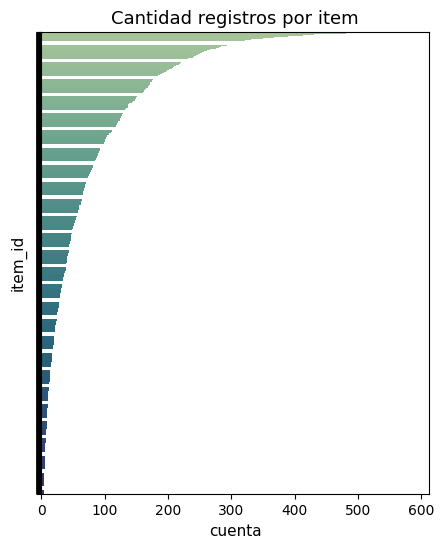

item_id  rating_mean  rating_std  cuenta
876       50     4.358491    0.881341     583
607      258     3.803536    0.994427     509
2        100     4.155512    0.975756     508
522      181     4.007890    0.923955     507
647      294     3.156701    1.098544     485
...      ...          ...         ...     ...
269     1257     1.750000    0.957427       4
328     1319     1.750000    0.957427       4
471     1539     1.750000    0.500000       4
812      442     1.250000    0.500000       4
1179     777     1.250000    0.500000       4

[1413 rows x 4 columns]

In [128]:
# Ver tabla de items - mayor cantidad registros

dfp = item_rating.merge(item_cuenta,how="inner",on="item_id").sort_values(["cuenta","rating_mean"],ascending=False)

figx = 5
figy = 6
fig, ax = plt.subplots(figsize=(figx,figy))
sns.barplot(data=dfp,x="cuenta",y="item_id",ax=ax, palette="crest")
ax.set_title("Cantidad registros por item", fontsize = 13)
ax.set_xlabel('cuenta', fontsize = 11)
ax.set_ylabel('item_id', fontsize = 11)
ax.set_yticklabels("", size = 0)
plt.show()

dfp

Ejemplo aplicación de algoritmo entrenado en usuario y item

In [132]:
# Seleccionar aleatoriamente un usuario y item (Ojo cuidado que estan invertidos desde origen)

val_item = random.sample(valores_item,1)
val_user = random.sample(valores_user,1)

print('User:',val_item)
print('Item:',val_user)

User: ['279']
Item: ['462']


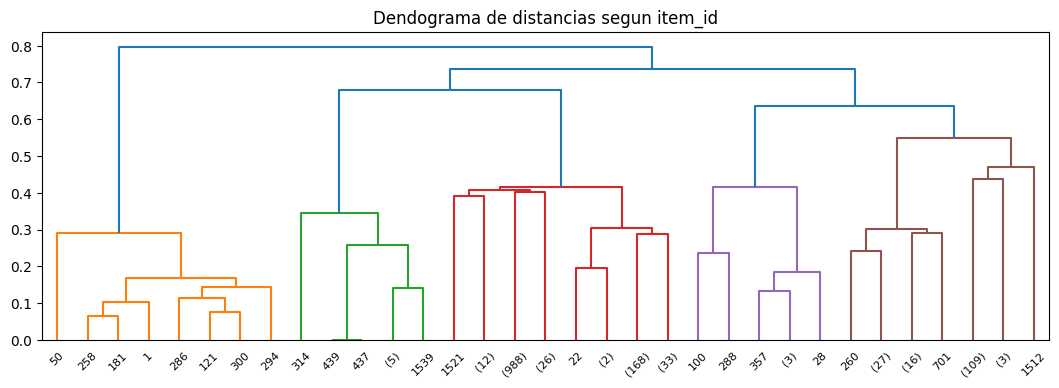

item_id  similar  cuenta  rating_mean  rating_std grupo
item_id                                                        
384         384      1.0      69     2.782609    1.012707   NaN
207         207      1.0      66     3.818182    1.006274   NaN
709         709      1.0     104     4.028846    0.897210   NaN
869         869      1.0      24     3.000000    1.063219   NaN
274         274      1.0     190     3.500000    0.963624   NaN
...         ...      ...     ...          ...         ...   ...
168         168      0.0     316     4.066456    0.994596   NaN
167         167      0.0      67     2.955224    0.894983   NaN
166         166      0.0      58     4.120690    0.727350   NaN
165         165      0.0      64     4.109375    0.856667   NaN
999         999      0.0      10     2.800000    1.135292   NaN

[1413 rows x 6 columns]

In [133]:
# Ranking de usuarios similares para el item seleccionado (ordenado de mayor a menor)

tipo_ref = "item_id"

valor = val_user[0]
similar = pd.DataFrame(data_pivot[valor].sort_values(ascending=False)).reset_index().rename(columns={valor:"similar","index":tipo_ref})
#similar = similar[similar[tipo_ref] != valor].copy()
similar = similar.merge(item_kpi,how="inner",on=tipo_ref)
similar.sort_values(["similar","rating_mean","rating_std","cuenta"],ascending=False)
similar.index = similar[tipo_ref]

###################

# Seleccionar variables a usar para dendograma
etiquetas = similar[tipo_ref].tolist()
df_dist = similar[["similar","rating_mean","rating_std","cuenta"]].copy()

# Normalizar variables para calculo de distancias
df_dist.rating_mean = (df_dist.rating_mean - df_dist.rating_mean.min())/(df_dist.rating_mean.max() - df_dist.rating_mean.min())
df_dist.rating_std = (df_dist.rating_std - df_dist.rating_std.min())/(df_dist.rating_std.max() - df_dist.rating_std.min())
df_dist.similar = (df_dist.similar - df_dist.similar.min())/(df_dist.similar.max() - df_dist.similar.min())
df_dist.cuenta = (df_dist.cuenta - df_dist.cuenta.min())/(df_dist.cuenta.max() - df_dist.cuenta.min())

# Dendograma segun distancias calculadas
fig = plt.figure(figsize=(13,4))
Z = hierarchy.linkage(pdist(df_dist,'euclidean'), 'average',optimal_ordering=True)
dn = dendrogram(Z,truncate_mode="level",p=5,labels=etiquetas)
plt.title('Dendograma de distancias segun ' + str(tipo_ref))
plt.show()

# asignar grupo segun dendograma
for elem,grupo in zip(dn["ivl"],dn["leaves_color_list"]):
    if(elem in similar.index):
        similar.loc[elem,"grupo"] = grupo

###################

similar

In [134]:
# Recorre cada par (item_id,user_id) y calcular rating asignado ... (Ojo cuidado que esta invertido el print!!!)

for user,item in zip(val_user,val_item):
    predice = modelo.predict(uid=str(user),iid=str(item), r_ui=None,clip=True)
    print("[Invertir item & user] :: ",predice)

[Invertir item & user] ::  user: 462        item: 279        r_ui = None   est = 3.15   {'was_impossible': False}


# 5. Ejemplo con Tensorflow Recommenders

Ejemplo extraido de: https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/quickstart.ipynb#scrollTo=sT8AyHRMNh41

In [323]:
# Generacion de datos de peliculas

# Cargar dataset - puntajes
ratings = tfds.load('movielens/100k-ratings', split="train")

# Cargar dataset - peliculas
movies = tfds.load('movielens/100k-movies', split="train")

# Seleccionar las variables de titulo de pelicula y usuario ID
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})

# Mapeo de peliculas
movies = movies.map(lambda x: x["movie_title"])

In [324]:
# Crear vocabulario para convertir ID de usuario y Titulo de peliculas en indices enteros

# vocabulario para usuarios ID
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

# vocabulario para titulo de peliculas
movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

In [325]:
# Definir clase para modelo

class MovieLensModel(tfrs.Model):

    def __init__(
          self,
          user_model: tf.keras.Model,
          movie_model: tf.keras.Model,
          task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie representations.
        self.user_model = user_model
        self.movie_model = movie_model

        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # Define how the loss is computed.

        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])

        return self.task(user_embeddings, movie_embeddings)

In [326]:
# Definir usuario y peliculas para el modelo

# Usuarios
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])

# Peliculas
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Definir objetivo
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)

In [328]:
# Crear modelo y entrenar

# Crea modelo 
model = MovieLensModel(user_model, movie_model, task)

# Compilar modelo - aqui se pueden agregar elementos adicionales (ejem: callbacks y otros)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Entrenar el modelo
epochs = 20
batch = 4096
print('Cantidad de epochs a entrenar: ',epochs,' ; Bloques (batch):',batch)
model.fit(ratings.batch(batch), epochs=epochs)

Cantidad de epochs a entrenar:  20  ; Bloques (batch): 4096
Epoch 1/20
25/25 [==============================] - 4s 153ms/step - factorized_top_k/top_1_categorical_accuracy: 3.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0060 - factorized_top_k/top_10_categorical_accuracy: 0.0141 - factorized_top_k/top_50_categorical_accuracy: 0.0951 - factorized_top_k/top_100_categorical_accuracy: 0.1958 - loss: 33993.5149 - regularization_loss: 0.0000e+00 - total_loss: 33993.5149
Epoch 2/20
25/25 [==============================] - 4s 152ms/step - factorized_top_k/top_1_categorical_accuracy: 9.6000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0097 - factorized_top_k/top_10_categorical_accuracy: 0.0248 - factorized_top_k/top_50_categorical_accuracy: 0.1609 - factorized_top_k/top_100_categorical_accuracy: 0.2948 - loss: 30364.9721 - regularization_loss: 0.0000e+00 - total_loss: 30364.9721
Epoch 3/20
25/25 [==============================] - 4s 153ms/step - factorized_top_k/top_1_categ

Dada la gran cantidad de datos vemos que los valores de "total loss" disminuyen, pero se debe tener en consideración la utilización de regularizadores (Ejemplo: earlystopping, regularizador L1/L2 u otros) con el fin de evitar un potencial sobre-ajuste a los datos de entrenamiento. (el objetivo es la generalización en datos no vistos)

In [329]:
# Realizar predicciones con el modelo entrenado

# Extraer predicciones
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
batch_maximo = 2000

index.index_from_dataset(
    movies.batch(batch_maximo).map(lambda title: (title, model.movie_model(title))))

#################################################

# Recomendacion para algunos usuarios - indicar el ID de persona
usuarios_id = [1,5,10,20,50,60,100,200,300,500,800]

# recorrer cada usuario
for usuario in usuarios_id:
    usuario = str(usuario)
    _, titles = index(np.array([usuario]))

    # Ver recomendación para usuario
    top_n = 3  # top ranking
    print('-----------------------------------------')
    print('Top peliculas para usuario id:',usuario)
    for i in titles.numpy().tolist()[0][:top_n]:
        print(str(i))

-----------------------------------------
Top peliculas para usuario id: 1
b'Brother Minister: The Assassination of Malcolm X (1994)'
b'Doom Generation, The (1995)'
b'Theodore Rex (1995)'
-----------------------------------------
Top peliculas para usuario id: 5
b'Amityville Curse, The (1990)'
b"Amityville 1992: It's About Time (1992)"
b'Amityville: A New Generation (1993)'
-----------------------------------------
Top peliculas para usuario id: 10
b'Wonderful, Horrible Life of Leni Riefenstahl, The (1993)'
b'Bad Moon (1996)'
b'Kicking and Screaming (1995)'
-----------------------------------------
Top peliculas para usuario id: 20
b'Island of Dr. Moreau, The (1996)'
b'Space Jam (1996)'
b'Miracle on 34th Street (1994)'
-----------------------------------------
Top peliculas para usuario id: 50
b'I Shot Andy Warhol (1996)'
b'Anne Frank Remembered (1995)'
b"Young Poisoner's Handbook, The (1995)"
-----------------------------------------
Top peliculas para usuario id: 60
b'Last Time I Saw

Observamos los titulos de peliculas obtenidos segun el ranking del modelo entrenado por cada usuario.